<font color="red" size="5"><b>CHANGE THE TITLE IN EACH GRAPH OF THE MODEL RUNS TO KNOW WHAT TECHNIQUE IT IS USING</b></font>

In [15]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, Matern
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.inspection import permutation_importance
import warnings
from sklearn.exceptions import ConvergenceWarning

# Suppress convergence warnings for cleaner output
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

sns.set_palette("deep")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [16]:
# Reading the data with pandas
data_booking = pd.read_csv('scraped_data/booking_results.csv')
data_expedia = pd.read_csv('scraped_data/expedia_results.csv')

In [17]:
# Preprocessing the data<
data_booking = data_booking.copy().drop(columns=['Subway Access', 'Nights & Adults', 'Payment Policy']) # Drop of the columns that are not useful
                                                                                                        # The payment policy column is not useful because the scraping code did not retrieved any data for this column
data_booking = data_booking.copy().dropna(subset=['Bed Type', 'Cancellation Policy']) # Drop of the rows with missing values
data_expedia = data_expedia.copy().dropna(subset=['Classification'])

data_booking = data_booking[data_booking['Review Class'] != 'Review score'] # Drop of the rows with the wrong values, "Review score" is not a valid category

columns_renamed_booking = [i.replace(' ', '_').lower() for i in data_booking.columns] # Renaming the columns to have a more readable name
columns_renamed_expedia = [i.replace(' ', '_').lower() for i in data_expedia.columns]
data_booking.columns = columns_renamed_booking
data_expedia.columns = columns_renamed_expedia

# Renaming columns in both dataframes to have the same names for similar data
data_booking.rename(columns={
    'total_price': 'price_after_tax',
    'score': 'rating',
    'number_of_reviews': 'reviews'
}, inplace=True)

data_expedia.rename(columns={
    'classification': 'review_class'
}, inplace=True)


data_booking['date_of_search'] = pd.to_datetime(data_booking['date_of_search']) # Converting 'date_of_search' in both data from object to datetime
data_expedia['date_of_search'] = pd.to_datetime(data_expedia['date_of_search'])

# Converting 'price_before_tax' in expedia from object to float
data_expedia['price_before_tax'] = data_expedia['price_before_tax'].copy().replace(',', '', regex=True)
data_expedia['price_before_tax'] = pd.to_numeric(data_expedia['price_before_tax'], errors='coerce')

## Overview of the data

Booking data

In [18]:
print('Booking data shape:', data_booking.shape)
data_booking.head(3)

Booking data shape: (7467, 17)


,ttt,los,date_of_search,index,hotel_name,rating,distance,price_before_tax,taxes,price_after_tax,stars,neighborhood,room_type,bed_type,cancellation_policy,review_class,reviews
2,1,1,2024-07-20,2,Four Points by Sheraton New York Downtown,7.4,7.0,119,21,140.0,3,Manhattan,"Guest room, 1 Queen",1 queen bed,Free cancellation,Good,2259
4,1,1,2024-07-20,4,Courtyard by Marriott Times Square West,8.2,1.8,151,26,177.0,3,Hell's Kitchen,King Room,1 king bed,Free cancellation,Very Good,2898
6,1,1,2024-07-20,6,Hilton Garden Inn New York Manhattan Midtown East,7.4,1.6,129,23,152.0,3,Midtown East,King Room,1 king bed,Free cancellation,Good,1431


Expedia data

In [19]:
print('Expedia data shape:', data_expedia.shape)
data_expedia.head(3)

Expedia data shape: (38271, 11)


,ttt,los,date_of_search,index,hotel_name,price_before_tax,price_after_tax,rating,review_class,reviews,neighborhood
0,1,1,2024-07-20,0,Millennium Hilton New York One UN Plaza,256,337,8.2,Very Good,1382,New York
1,1,1,2024-07-20,1,Moxy NYC Chelsea,290,370,8.6,Excellent,1020,Chelsea
2,1,1,2024-07-20,2,Penny Williamsburg,379,410,9.4,Exceptional,532,Williamsburg


## Part B - data exploration

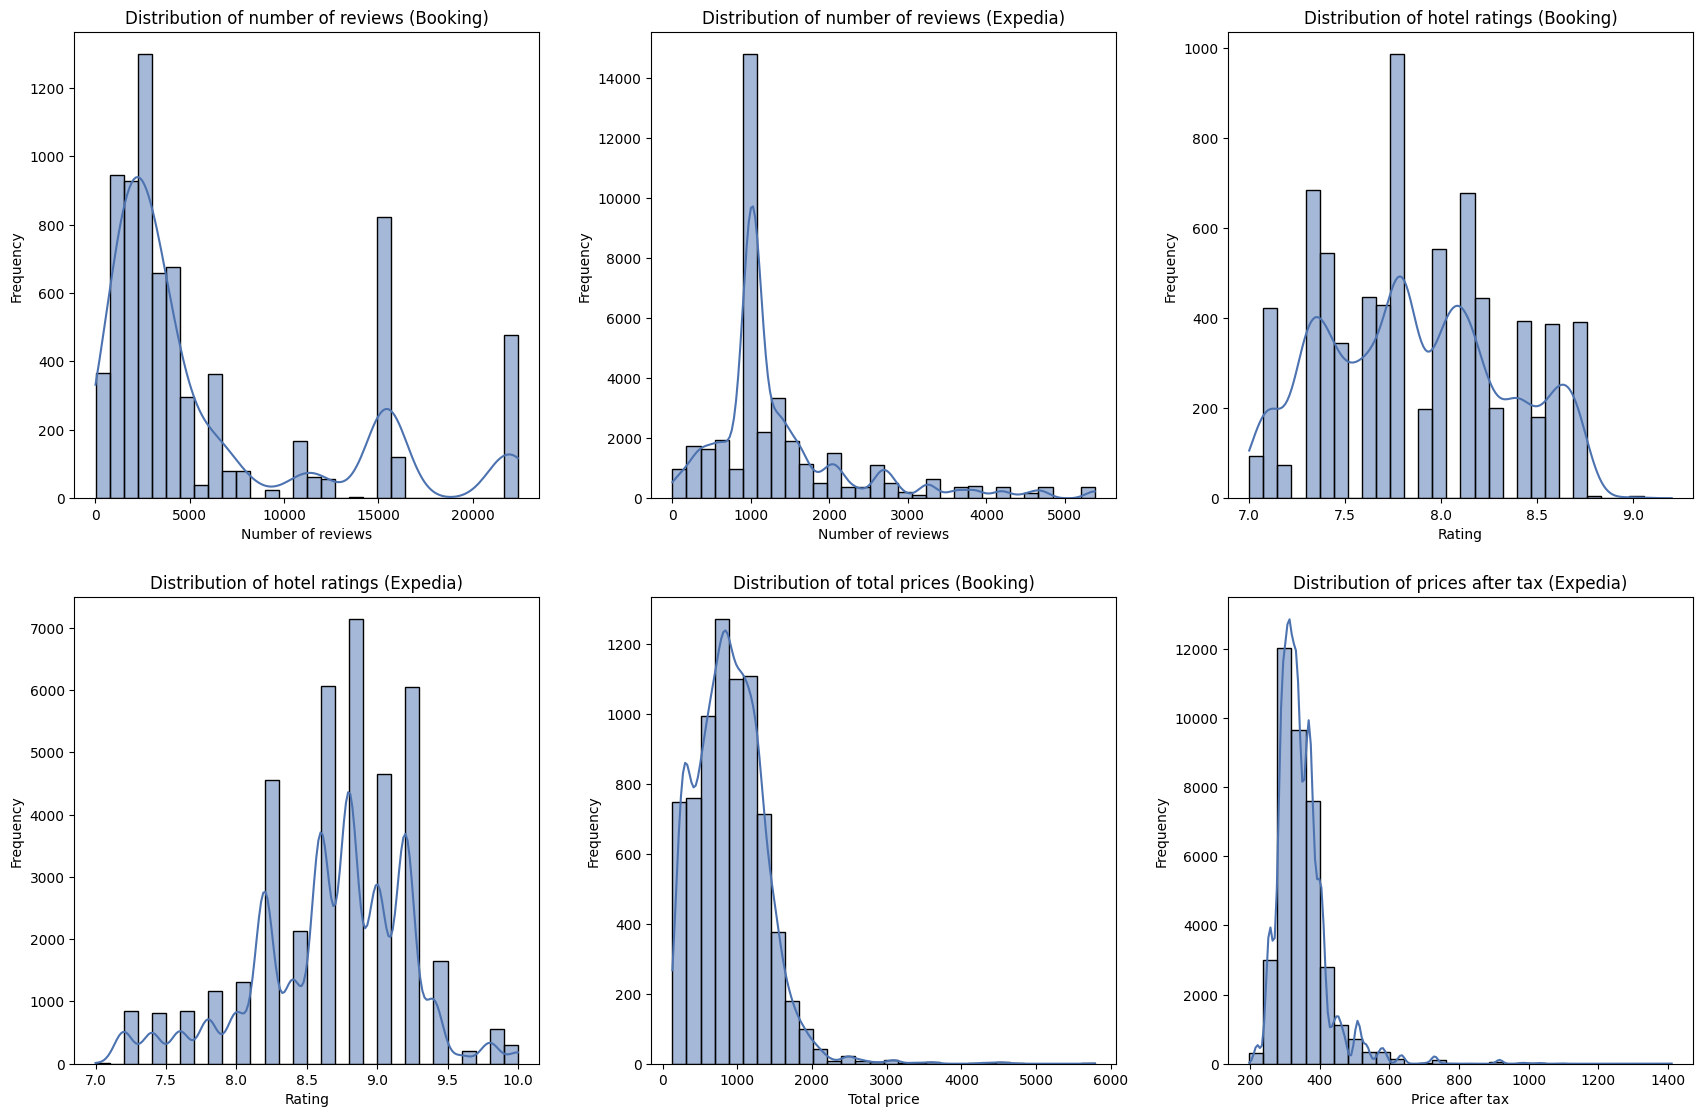

In [20]:
# Distribution graphs for the number of reviews, ratings and prices

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.tight_layout(pad=5.0) # Adjusting the space between the plots

# Distribution of number of reviews
sns.histplot(data_booking['reviews'], kde=True, bins=30, ax=axes[0, 0])
axes[0, 0].set_title('Distribution of number of reviews (Booking)')
axes[0, 0].set_xlabel('Number of reviews')
axes[0, 0].set_ylabel('Frequency')

sns.histplot(data_expedia['reviews'], kde=True, bins=30, ax=axes[0, 1])
axes[0, 1].set_title('Distribution of number of reviews (Expedia)')
axes[0, 1].set_xlabel('Number of reviews')
axes[0, 1].set_ylabel('Frequency')

# Distribution of hotel ratings
sns.histplot(data_booking['rating'], kde=True, bins=30, ax=axes[0, 2])
axes[0, 2].set_title('Distribution of hotel ratings (Booking)')
axes[0, 2].set_xlabel('Rating')
axes[0, 2].set_ylabel('Frequency')

sns.histplot(data_expedia['rating'], kde=True, bins=30, ax=axes[1, 0])
axes[1, 0].set_title('Distribution of hotel ratings (Expedia)')
axes[1, 0].set_xlabel('Rating')
axes[1, 0].set_ylabel('Frequency')

# Distribution of prices
sns.histplot(data_booking['price_after_tax'], kde=True, bins=30, ax=axes[1, 1])
axes[1, 1].set_title('Distribution of total prices (Booking)')
axes[1, 1].set_xlabel('Total price')
axes[1, 1].set_ylabel('Frequency')

sns.histplot(data_expedia['price_after_tax'], kde=True, bins=30, ax=axes[1, 2])
axes[1, 2].set_title('Distribution of prices after tax (Expedia)')
axes[1, 2].set_xlabel('Price after tax')
axes[1, 2].set_ylabel('Frequency')

plt.show()

In [21]:
# Removing outliers from the data using the IQR method
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25) # Calculating the first quartile (25th percentile)
    Q3 = df[column].quantile(0.75) # Calculating the third quartile (75th percentile)
    IQR = Q3 - Q1 # Calculating the onterquartile range, defined as the difference between the third and first quartiles 
    lower_bound = Q1 - 1.5 * IQR # Calculaing the lower bound for outliers
    upper_bound = Q3 + 1.5 * IQR # Calculating the upper bound for outliers
    
    # Returning the DataFrame with outliers removed
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Applying the funciton to both booking and expedia data
data_booking = remove_outliers(data_booking, 'price_after_tax')
data_expedia = remove_outliers(data_expedia, 'price_after_tax')

Note for encoding: Since the bed type column has only been retrieved from booking website, because that was the only that allowed it, and due to the big amount of categories that are in this column, then it was not possible to encode the column by order relation.

In [22]:
# Encoding of the data

# Ordinal encoding for review_class in both Booking and Expedia
ordinal_mapping_booking = {
    'Good': 1,
    'Very Good': 2,
    'Excellent': 3,
    'Wonderful': 4
}

ordinal_mapping_expedia = {
    'Good': 1,
    'Very Good': 2,
    'Excellent': 3,
    'Wonderful': 4,
    'Exceptional': 5
}

# Applying the ordinal encoding to the data
data_booking['review_class'] = data_booking['review_class'].map(ordinal_mapping_booking)
data_expedia['review_class'] = data_expedia['review_class'].map(ordinal_mapping_expedia)

def encode_features(data_booking, data_expedia):
    """"Function to encode the categorical features in the dataframes using one-hot encoding and label encoding"""
    # One-Hot encoding for Booking
    one_hot_booking = pd.get_dummies(data_booking[['cancellation_policy', 'neighborhood', 'bed_type', 'room_type']],
                                     prefix=['cancel_policy', 'neighborhood', 'bed_type', 'room_type'])
    data_booking = pd.concat([data_booking, one_hot_booking], axis=1)
    # Drop of the original columns after encoding
    data_booking.drop(['cancellation_policy', 'neighborhood', 'bed_type', 'room_type'], axis=1, inplace=True)

    # One-Hot Encoding for Expedia
    one_hot_expedia = pd.get_dummies(data_expedia[['neighborhood']], prefix=['neighborhood'])
    data_expedia = pd.concat([data_expedia, one_hot_expedia], axis=1)
    # Drop original column after encoding
    data_expedia.drop(['neighborhood'], axis=1, inplace=True)

    # Label Encoding for hotel_name in both Booking and Expedia
    label_encoder_booking = LabelEncoder()
    data_booking['hotel_name_encoded'] = label_encoder_booking.fit_transform(data_booking['hotel_name'])
    data_booking.drop(['hotel_name'], axis=1, inplace=True)

    label_encoder_expedia = LabelEncoder()
    data_expedia['hotel_name_encoded'] = label_encoder_expedia.fit_transform(data_expedia['hotel_name'])
    data_expedia.drop(['hotel_name'], axis=1, inplace=True)

    return data_booking, data_expedia

# Applying the encoding function to the data
data_booking_processed, data_expedia_processed = encode_features(data_booking, data_expedia)

For both platforms, booking and expedia based on the pairgrid graphs, there's a strong positive correlation between price_after_tax and price_before_tax, which is expected. In the Booking data, hotel ratings show a moderate positive correlation with price, suggesting that higher-rated hotels tend to be more expensive. The number of reviews appears to have a weak positive relationship with price, indicating that more reviewed hotels might be slightly pricier. Interestingly, the 'stars' variable in the Booking data shows a clear positive correlation with price, confirming that higher star-rated hotels command higher prices. The 'distance' variable seems to have a slight negative correlation with price, possibly suggesting that hotels closer to the city center (assuming distance is measured from the center) are more expensive. 

For Expedia, similar trends are observed, though the relationships appear somewhat weaker, but this can be due to the fact that there is many more data in the expedia dataframe that in the booking, so the relationships here can be more accurate. The review_class variable in both datasets shows a positive relationship with price, indicating that hotels with better review classifications tend to be more expensive.

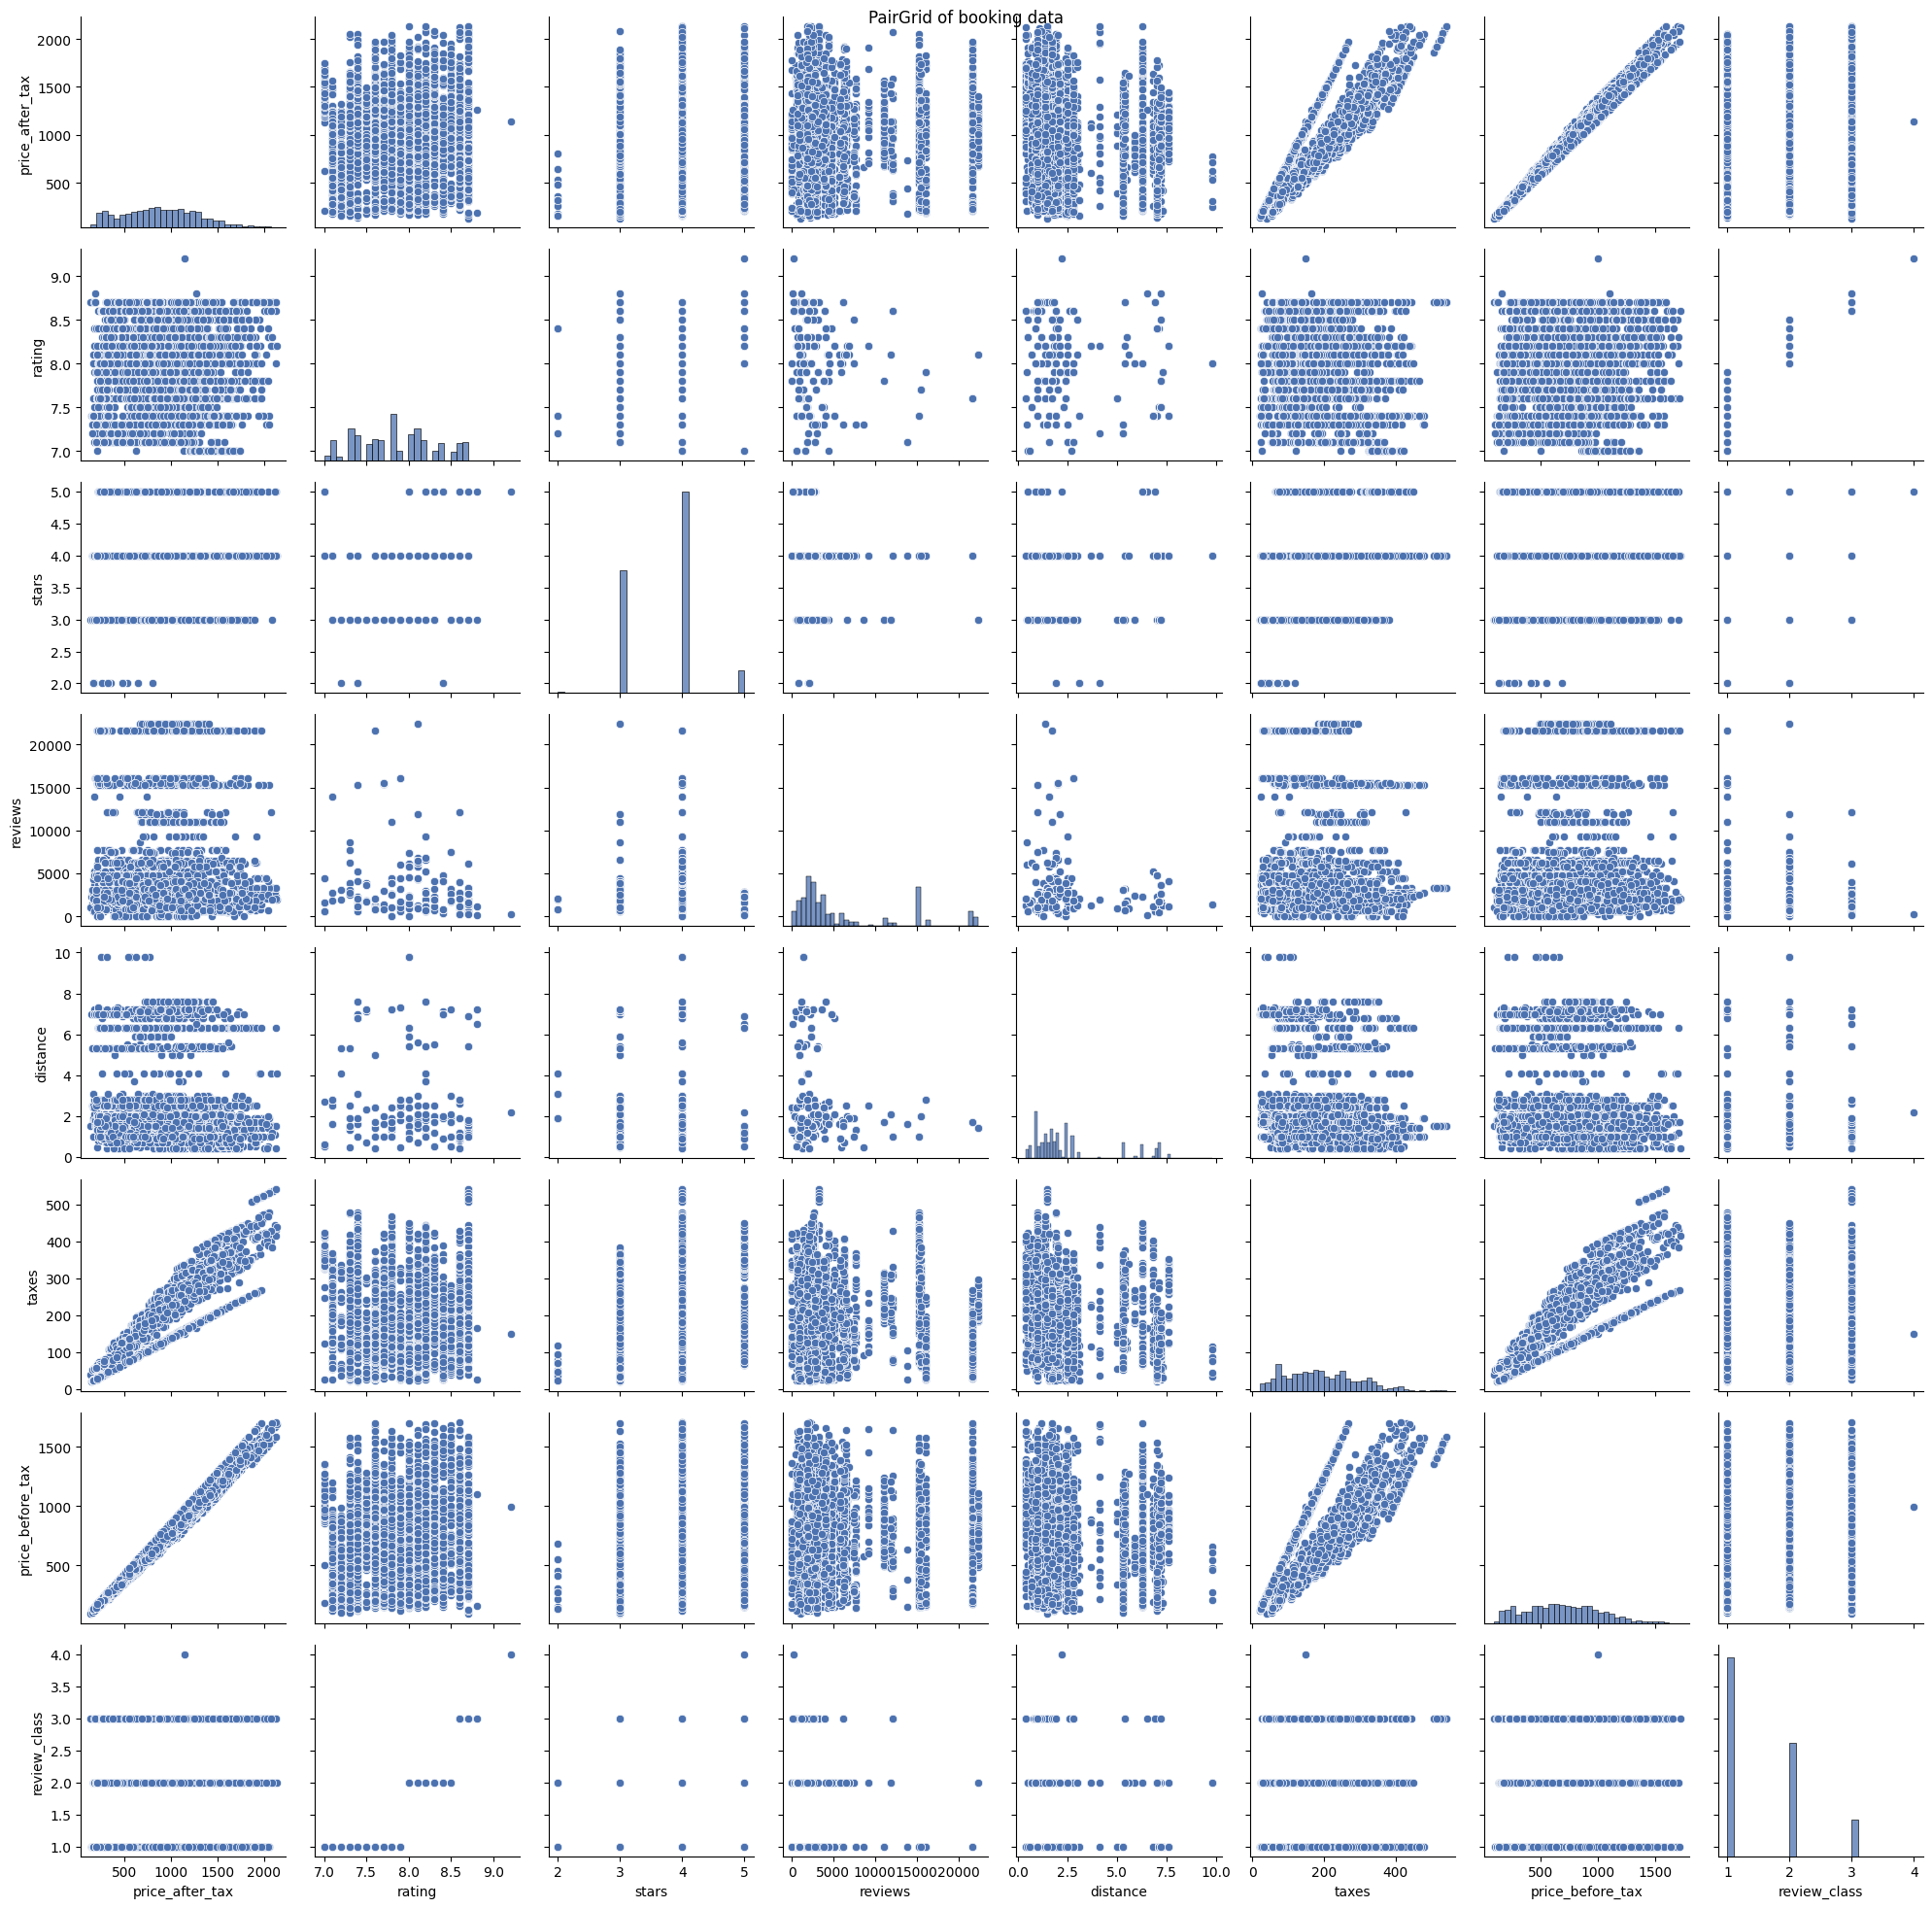

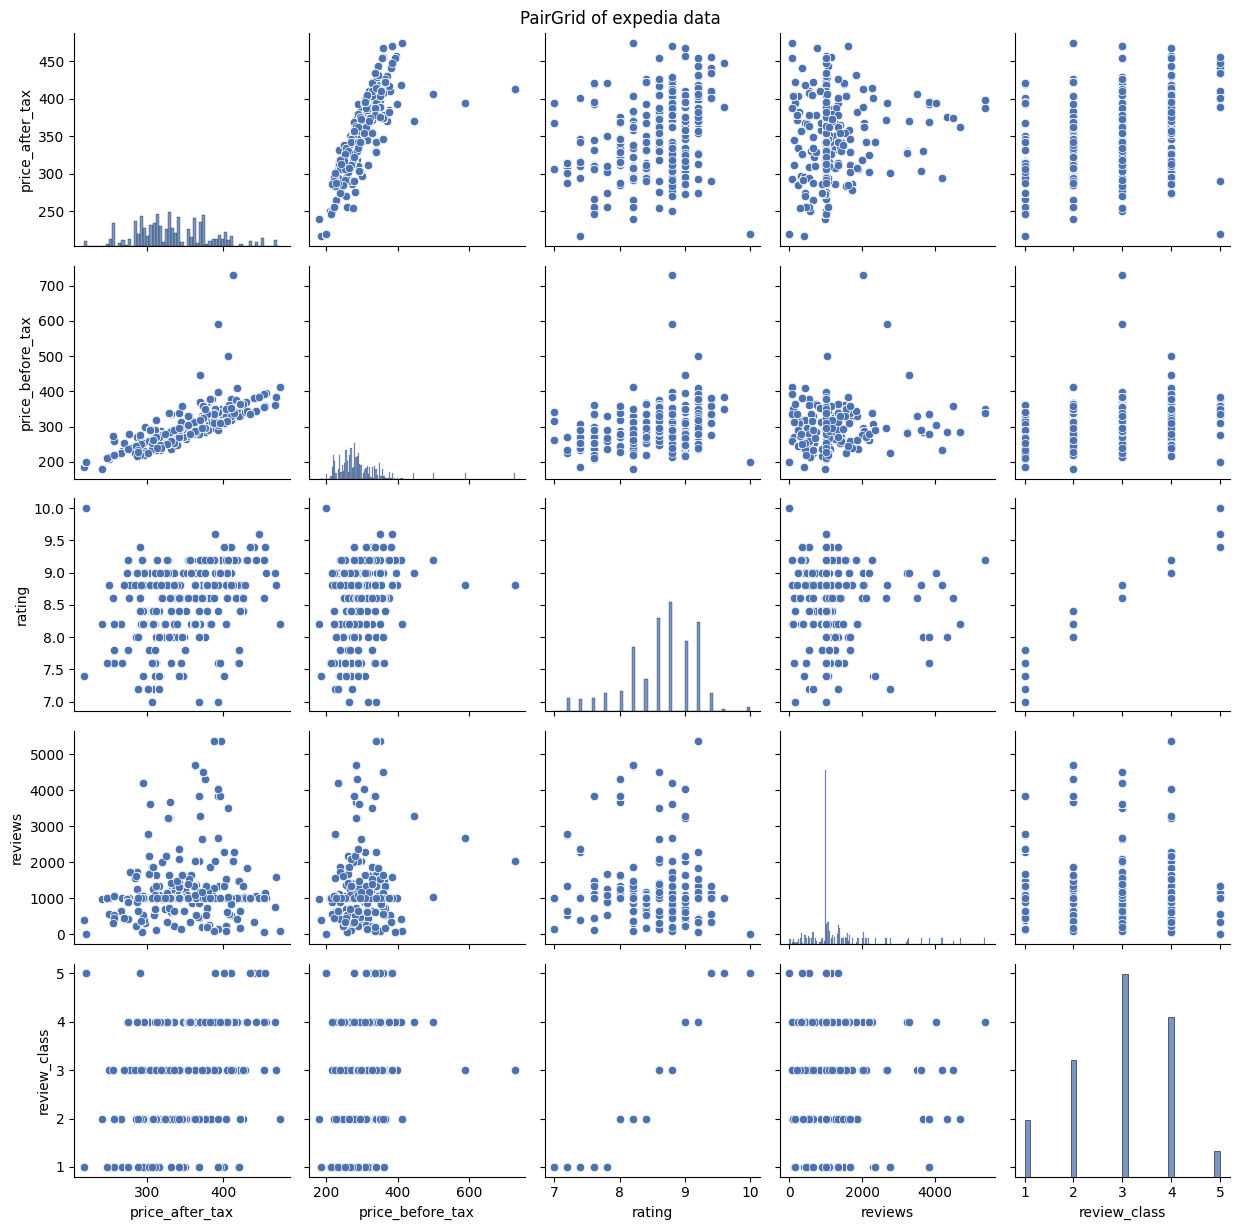

In [28]:
#PairGrid analysis
sns.pairplot(data_booking[['price_after_tax', 'rating', 'stars', 'reviews', 'distance', 'taxes', 'price_before_tax', 'review_class']])
plt.suptitle('PairGrid of booking data')
plt.tight_layout()
plt.show()

sns.pairplot(data_expedia[['price_after_tax', 'price_before_tax','rating', 'reviews', 'review_class']])
plt.suptitle('PairGrid of expedia data')
plt.tight_layout()
plt.show()

## Part C -  prediction of rooms prices

Running the models without feature engineering applied

To make this part I decided to make a function that contains what the task requires to be run in the code in various cells where it is required 

**Conclusions from the first run of the code without any change in the data, only the encoding:**

For the Booking data, most algorithms performed exceptionally well, with Linear Regression, Ridge Regression, and KNeighbors Regressor achieving near-perfect R2 scores on both train and test sets. This suggests that the relationship between features and price in the Booking dataset might be highly linear or easily captured by these models. However, such perfect scores are unusual and might indicate potential data leakage or overfitting issues that should be investigated further. The Decision Tree Regressor and Random Forest Regressor also performed very well on the Booking data, with high R2 scores and low error rates. These tree-based methods can capture non-linear relationships and interactions between featres, which might explain their strong performance if the data has complex patterns. Knowing that near perfect scores are rare and might indicate overfitting, I suggest that the best model here in Booking data was the Random Forest Regressor model based on its metrics. Interestingly, the Gaussian Process Regressor showed a significant drop in performance on the test set for Booking data, with an R2 score of 0.7 +- compared to 1.0 on the training set. This substantil difference between train and test performance indicates overfitting, likely due to the model's flexibility in capturing complex patterns that don't generalize well to unseen data.

For the Expedia data, I see a different pattern. Linear Regression and Ridge Regression performed similarly but much worse than on the Booking data, wit R2 scores around 0.58. This suggests that the relattionship between features and price in the Expedia dataset is less linear and more complex. Also considering that Expedia has far more data than Booking, than I think its better to trust these models compared to the Booking ones. The tree-based methods (Decision Tree and Random Forest) and KNeighbors Regressor performed excepttionally well on the Expedia data, with R2scores above 0.99 on both train and test sets. Their ability to capture non-linear relationships and local patterns in the data likely contributed to their superior performance. The Gaussian Process Regressor showed extremely poor performance on the Expedia test data, with a negative R2 score, indicating that it performed worse than a horizontal line predicting the mean price.

In both datasets, the simpler models (Linear Regression, Ridge Regression) showed consistent performance between train and test sets, indicating good generalization. However, their performance varied greatly between the two datasets, highlighting the differences in the underlying data structures. The tree-based methods and KNeighbors Regressor demnstrated strong performance across both datasets, suggesting they are roubust to different data characteristics. However, their near-perfect scores, especially on the Booking data, warrant further investigation to ensure there's no data leakage or other issues inflating their performance. The Gaussian Process Regressor's inconsistent performance across datasets and between train and test sets underscores its sensitivity to hyperparameters and potentialz for overfitting, especially on smaller datasets or with complex kernel choices.

Booking Data:
Training Linear Regression...
Training Decision Tree Regressor...
Training Gaussian Process Regressor...
Training Random Forest Regressor...
Training Ridge Regression...
Training KNeighbors Regressor...


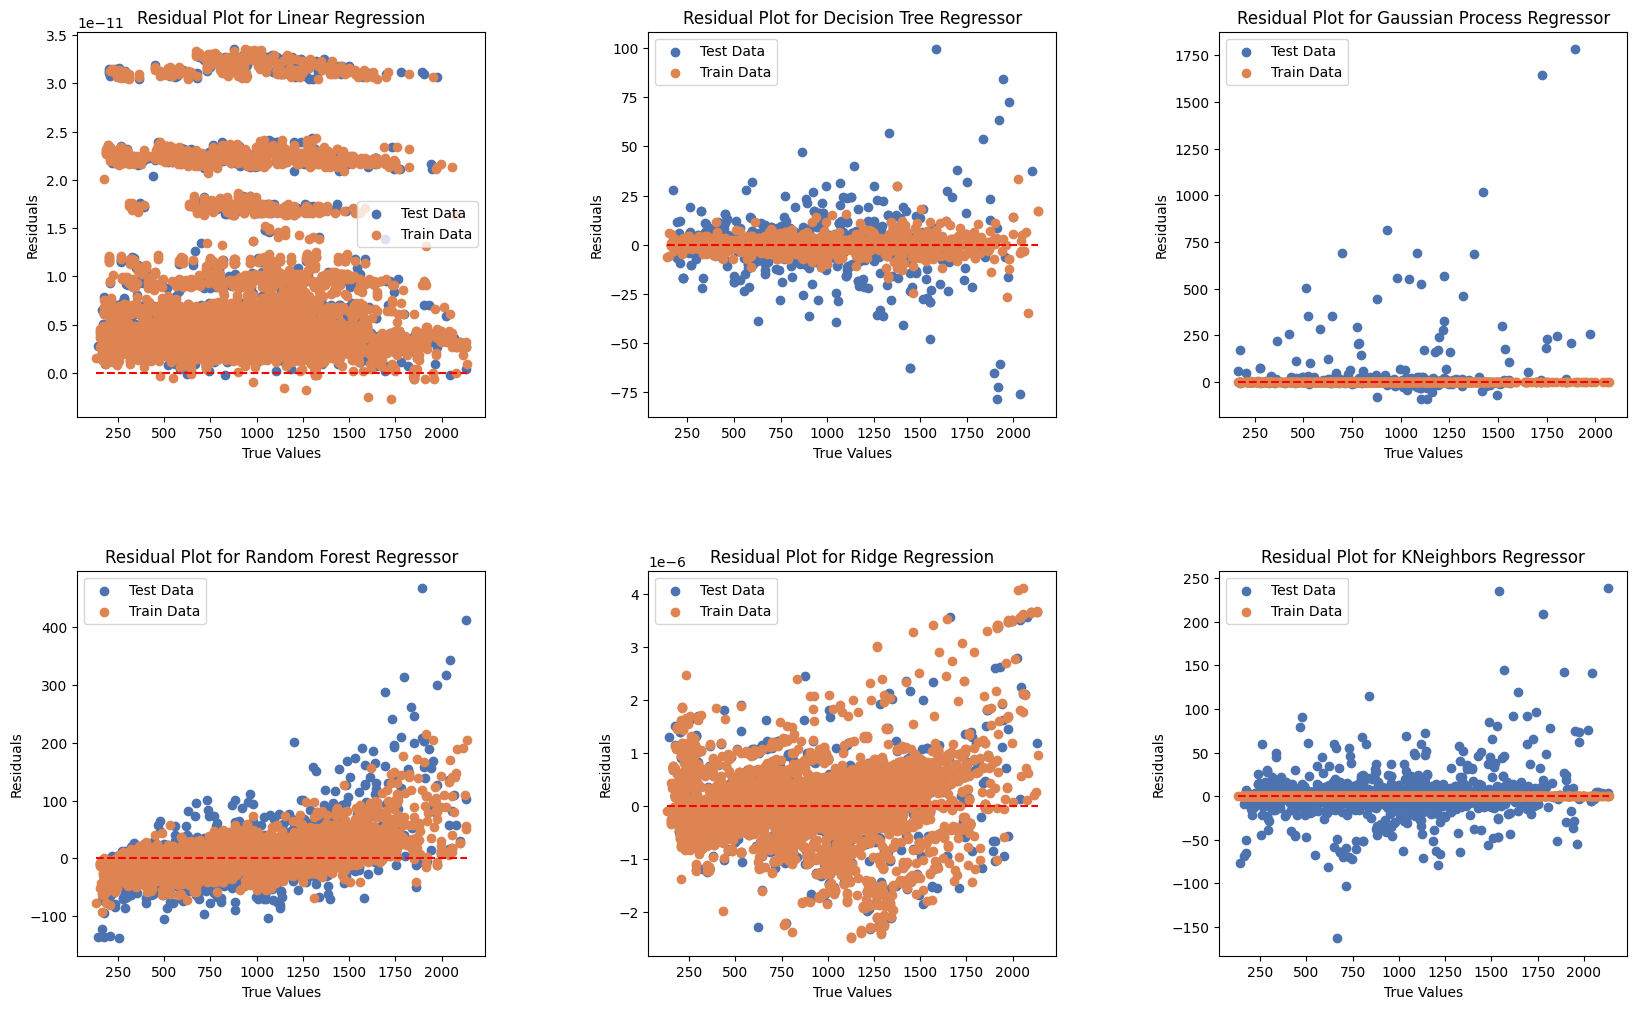

                        Model  \
0           Linear Regression   
1     Decision Tree Regressor   
2  Gaussian Process Regressor   
3     Random Forest Regressor   
4            Ridge Regression   
5        KNeighbors Regressor   

                                         Best Params     MSE Train  \
0                           {'fit_intercept': False}  1.616413e-22   
1  {'min_samples_split': 5, 'max_depth': 20, 'cri...  9.432976e+00   
2                                    {'alpha': 0.01}  4.507209e-03   
3  {'n_estimators': 100, 'min_samples_split': 2, ...  6.047354e+02   
4             {'alpha': 0.1, 'fit_intercept': False}  4.132883e-13   
5  {'weights': 'distance', 'p': 1, 'n_neighbors': 3}  0.000000e+00   

       MSE Test    RMSE Train     RMSE Test     MAE Train      MAE Test  \
0  1.683354e-22  1.271382e-11  1.297441e-11  9.206313e-12  9.427119e-12   
1  1.638323e+02  3.071315e+00  1.279970e+01  1.422619e+00  6.610648e+00   
2  4.144348e+04  6.713575e-02  2.035767e+02  2.98520

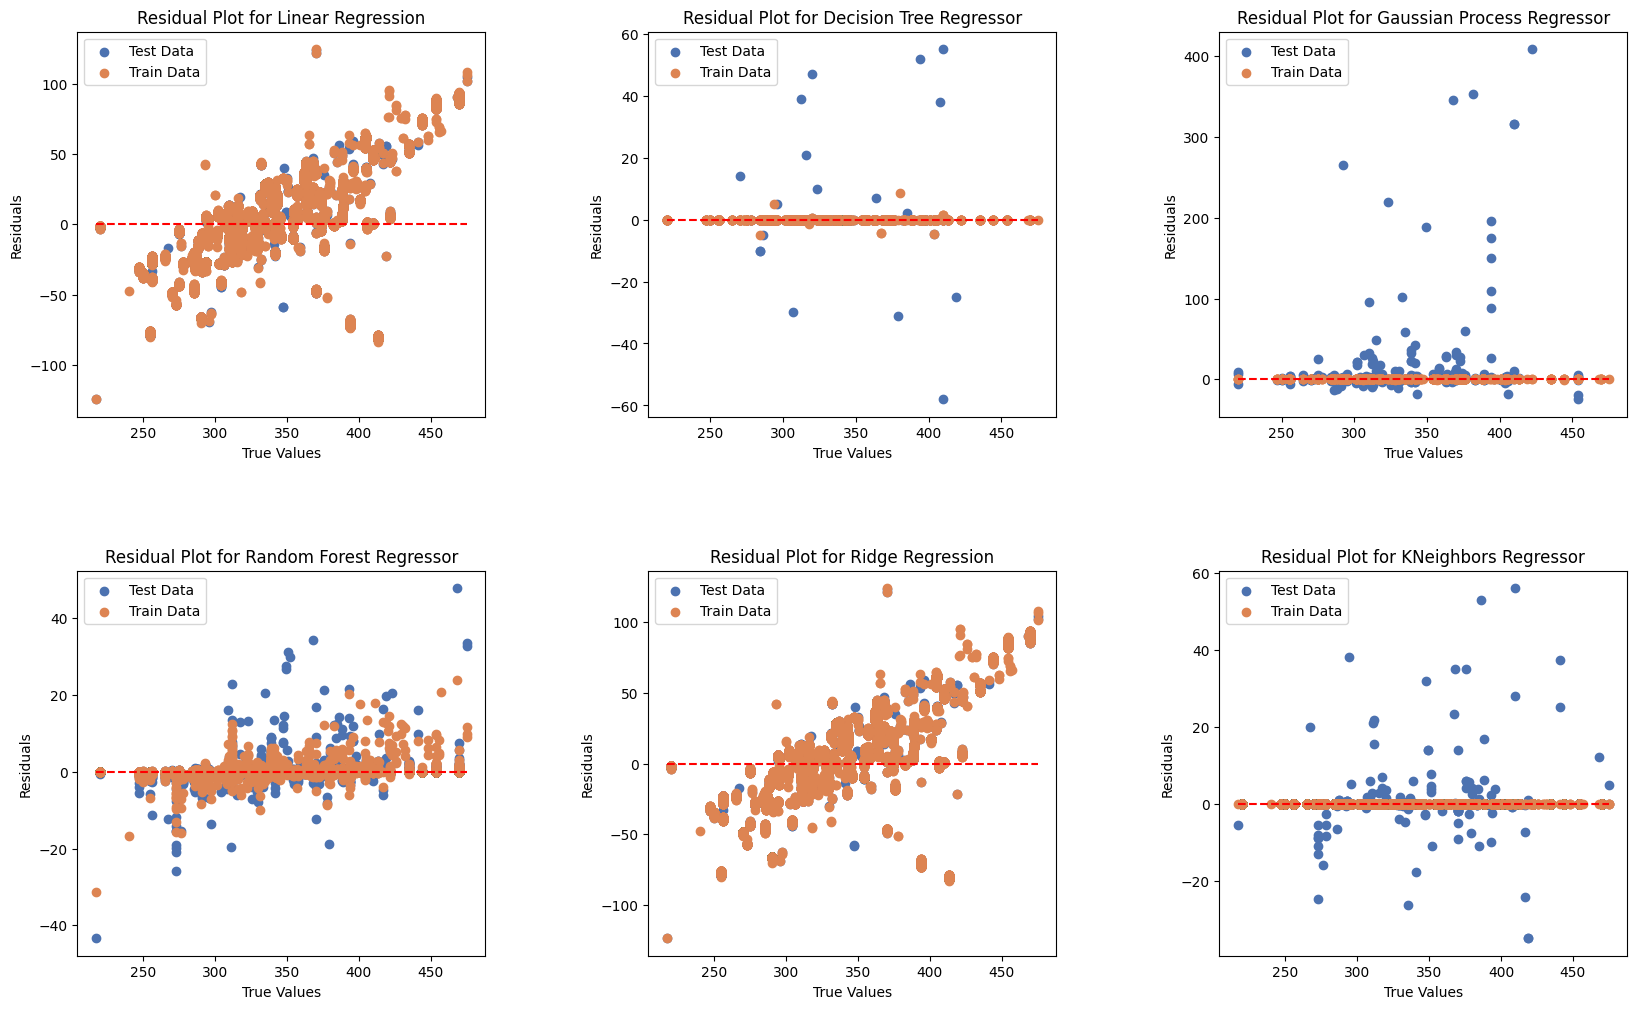

                        Model  \
0           Linear Regression   
1     Decision Tree Regressor   
2  Gaussian Process Regressor   
3     Random Forest Regressor   
4            Ridge Regression   
5        KNeighbors Regressor   

                                         Best Params   MSE Train     MSE Test  \
0                            {'fit_intercept': True}  967.700479   965.161070   
1  {'min_samples_split': 5, 'max_depth': 20, 'cri...    0.091587    19.792994   
2                                    {'alpha': 0.01}    0.001840  3085.314258   
3  {'n_estimators': 100, 'min_samples_split': 2, ...    0.511333     2.357385   
4                {'alpha': 1, 'fit_intercept': True}  967.712946   965.189888   
5  {'weights': 'distance', 'p': 1, 'n_neighbors': 3}    0.000000     2.162500   

   RMSE Train  RMSE Test  MAE Train   MAE Test  R2 Train   R2 Test  
0   31.107885  31.067042  23.045236  22.948606  0.580209  0.579063  
1    0.302634   4.448932   0.018571   0.515741  0.999959  0.99

In [18]:
# Function to train and evaluate models
def train_and_evaluate_models(data, target_column):
    # Models to be trained
    models = {
        "Linear Regression": LinearRegression(),
        "Decision Tree Regressor": DecisionTreeRegressor(),
        "Gaussian Process Regressor": GaussianProcessRegressor(kernel=C(1.0, (1e-4, 1e3)) * RBF(1.0, (1e-4, 1e2))), # These first three are the ones required
        "Random Forest Regressor": RandomForestRegressor(), # These last three are the optional I choose
        "Ridge Regression": Ridge(),
        "KNeighbors Regressor": KNeighborsRegressor()
    }

    # Hyperparameters to tune in the models using GridSearchCV
    param_grids = {
        "Linear Regression": {
            'fit_intercept': [True, False]
        },
        "Decision Tree Regressor": {
            'max_depth': [5, 10, 20, None],
            'min_samples_split': [2, 5, 10],
            'criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson']
        },
        "Gaussian Process Regressor": {
            'alpha': [1e-2, 1e-3],
        },
        "Random Forest Regressor": {
            'n_estimators': [50, 100, 200],
            'max_features': ['sqrt', 'log2'],
            'max_depth': [10, 20, None],
            'min_samples_split': [2, 5, 10]
        },
        "Ridge Regression": {
            'alpha': [0.1, 1, 10],
            'fit_intercept': [True, False],
        },
        "KNeighbors Regressor": {
            'n_neighbors': [3, 5, 7, 10],
            'weights': ['uniform', 'distance'],
            'p': [1, 2]
        }
    }

    # Setting up a 2x3 grid of subplots to show the graphs of the residualsq
    fig, axs = plt.subplots(2, 3, figsize=(20, 12))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)

    plot_row, plot_col = 0, 0 # Counter to plot, subplot index to plot the residuals

    # Defining sample sizes for specific models
    # Due to the high computational cost of these models I decided to sample the data from the start to reduce the time of training
    sample_sizes = {
        "Decision Tree Regressor": 7000,
        "Gaussian Process Regressor": 3000
    }

    # Training and evaluating the models
    results = [] # List to store the results of the models
    for model_name, model in models.items():
        print(f"Training {model_name}...")

        # Checking if the model requires sampling and if the data size exceeds the threshold
        if model_name in sample_sizes and len(data) > 7000:
            sampled_data = data.sample(n=sample_sizes[model_name], random_state=42) # Sampling the data
            X = sampled_data.drop(columns=[target_column]) # Splitting the data into features and target
            y = sampled_data[target_column]
        else:
            X = data.drop(columns=[target_column]) # Else doing the same with the whole data
            y = data[target_column]

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) # Splitting the data into training and testing as required

        # Using GridSearchCV to tune the hyperparameters before mentioned
        if model_name in param_grids:
            param_grid = param_grids[model_name]
            model = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
        model.fit(X_train, y_train)
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)

        # Calculation of error metrics
        mse_train = mean_squared_error(y_train, y_pred_train)  # Mean Squared Error for training data
        mse_test = mean_squared_error(y_test, y_pred_test)     # Mean Squared Error for test data
        rmse_train = np.sqrt(mse_train)                        # Root Mean Squared Error for training data
        rmse_test = np.sqrt(mse_test)                          # Root Mean Squared Error for test data
        mae_train = mean_absolute_error(y_train, y_pred_train) # Mean Absolute Error for training data
        mae_test = mean_absolute_error(y_test, y_pred_test)    # Mean Absolute Error for test data
        r2_train = r2_score(y_train, y_pred_train)             # R-squared for training data
        r2_test = r2_score(y_test, y_pred_test)                # R-squared for test data
        results.append({
            "Model": model_name,
            "Best Params": model.best_params_ if hasattr(model, 'best_params_') else None,
            "MSE Train": mse_train,
            "MSE Test": mse_test,
            "RMSE Train": rmse_train,
            "RMSE Test": rmse_test,
            "MAE Train": mae_train,
            "MAE Test": mae_test,
            "R2 Train": r2_train,
            "R2 Test": r2_test
        }) # Creating a results dataframe with the metrics and best parameters

        # Plot of the residuals
        ax = axs[plot_row, plot_col]
        ax.scatter(y_test, y_test - y_pred_test, label="Test Data")  # Plot of residuals for test data
        ax.scatter(y_train, y_train - y_pred_train, label="Train Data")  # Plot of residuals for training data
        ax.hlines(y=0, xmin=min(y), xmax=max(y), colors='r', linestyles='dashed')  # Drawing a horizontal line at y=0 forreference
        ax.set_xlabel("True values")
        ax.set_ylabel("Residuals")
        ax.set_title(f"Residual plot for {model_name}")
        ax.legend()

        # Updating subplot index
        plot_col += 1
        if plot_col > 2:
            plot_col = 0
            plot_row += 1

    plt.show()

    # Displaying results
    results_df = pd.DataFrame(results)
    return results_df

# Apply the function to both datasets
print("Booking Data:")
results_booking = train_and_evaluate_models(data_booking_processed.drop(columns='date_of_search'), 'price_after_tax')
print(results_booking)

print("\nExpedia Data:")
results_expedia = train_and_evaluate_models(data_expedia_processed.drop(columns='date_of_search'), 'price_after_tax')
print(results_expedia)

Running the function with the feature engineering applied

**Conclusions from the second run of the code with feature engineering applied to the data:**

The comparison of results with and without feature engineering reveals minimal impact on model performance for both Booking and Expedia datasets. For Booking, Linear Regression and Ridge Regression maintained their perfect performance, while other models showed slight decreases in R2 scores. The Decision Tree Regressor exhibited an insignificant improvement in test R2 but a small decrease in train R2. The Expedia data showed similarly minor changes, with Linear Regression and Ridge Regression seeing very slight improvements, while tree-based methods and KNeighbors Regressor experienced small decreases in performance.

These results suggest that the original features were already capturing most of the relevant information for price prediction, and the additional engineered features did not contribute significant new insights. The consistently high performance of linear models across both datasets indicates that the relationship between features and price might be predominantly linear, which could explain why more complex models didn't benefit substantially from the new features.

Booking Data:
Training Linear Regression...
Training Decision Tree Regressor...
Training Gaussian Process Regressor...
Training Random Forest Regressor...
Training Ridge Regression...
Training KNeighbors Regressor...


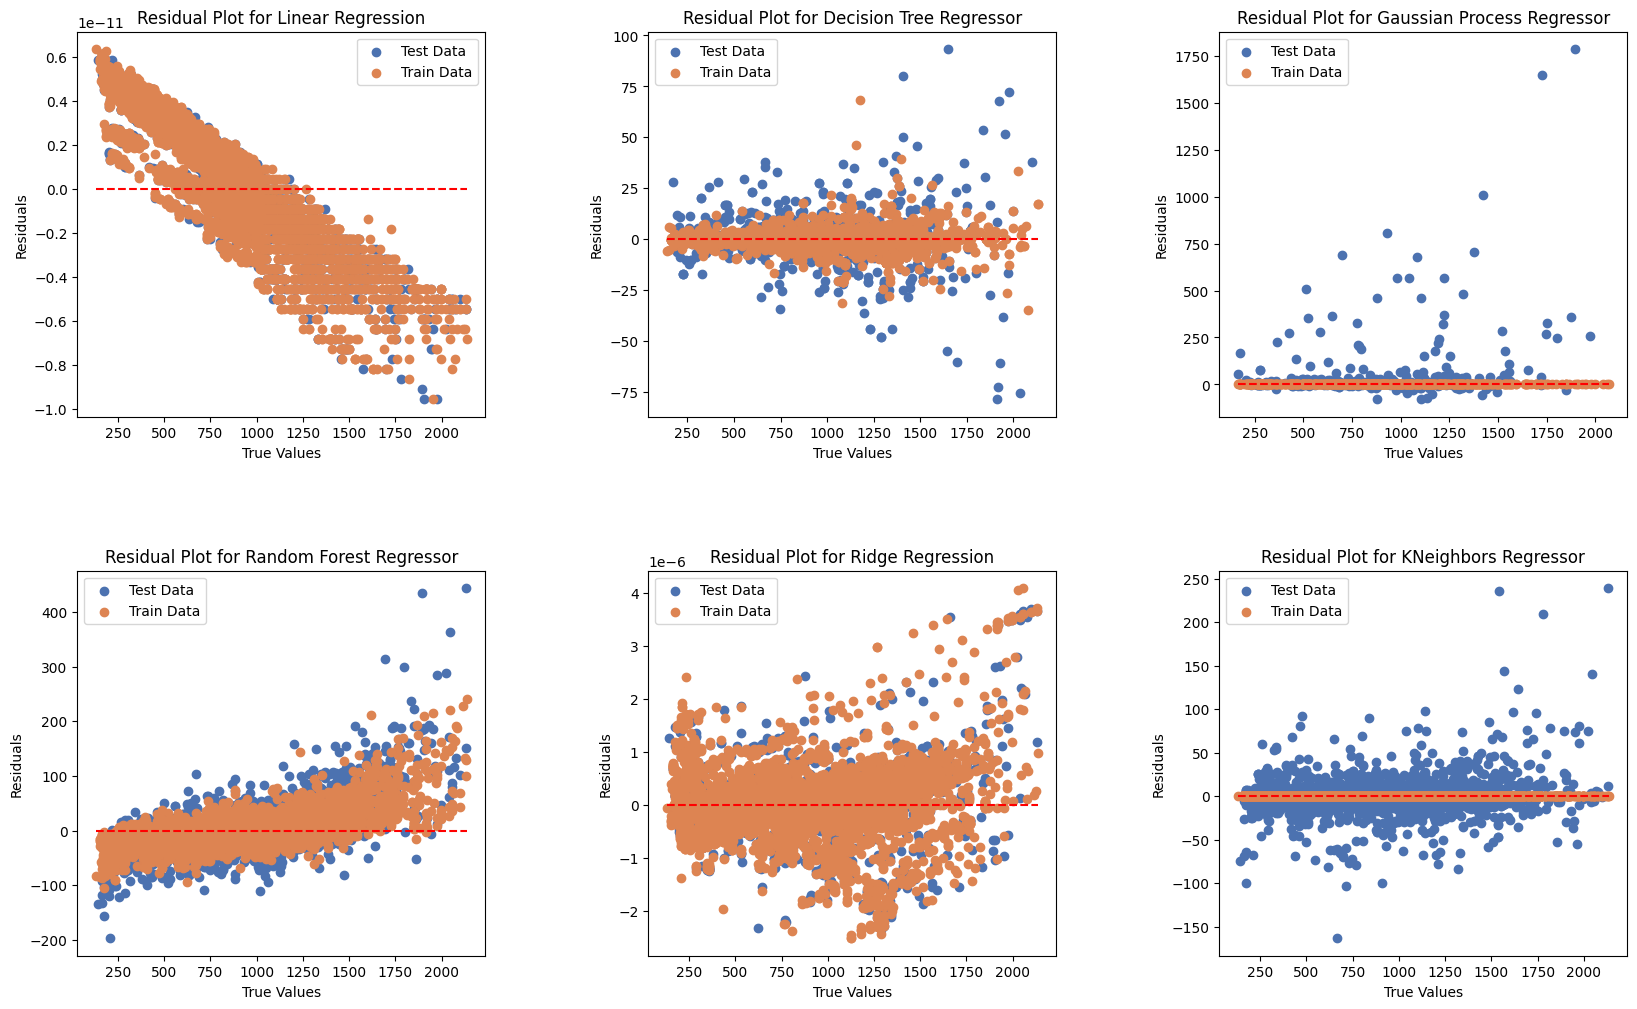

                        Model  \
0           Linear Regression   
1     Decision Tree Regressor   
2  Gaussian Process Regressor   
3     Random Forest Regressor   
4            Ridge Regression   
5        KNeighbors Regressor   

                                         Best Params     MSE Train  \
0                            {'fit_intercept': True}  8.529770e-24   
1  {'min_samples_split': 5, 'max_depth': 10, 'cri...  2.891359e+01   
2                                   {'alpha': 0.001}  6.039482e-06   
3  {'n_estimators': 100, 'min_samples_split': 2, ...  9.373956e+02   
4              {'alpha': 0.1, 'fit_intercept': True}  4.144598e-13   
5  {'weights': 'distance', 'p': 1, 'n_neighbors': 3}  0.000000e+00   

       MSE Test    RMSE Train     RMSE Test     MAE Train      MAE Test  \
0  8.577183e-24  2.920577e-12  2.928683e-12  2.432256e-12  2.436802e-12   
1  1.872038e+02  5.377136e+00  1.368224e+01  2.951511e+00  7.840948e+00   
2  4.259556e+04  2.457536e-03  2.063869e+02  1.26595

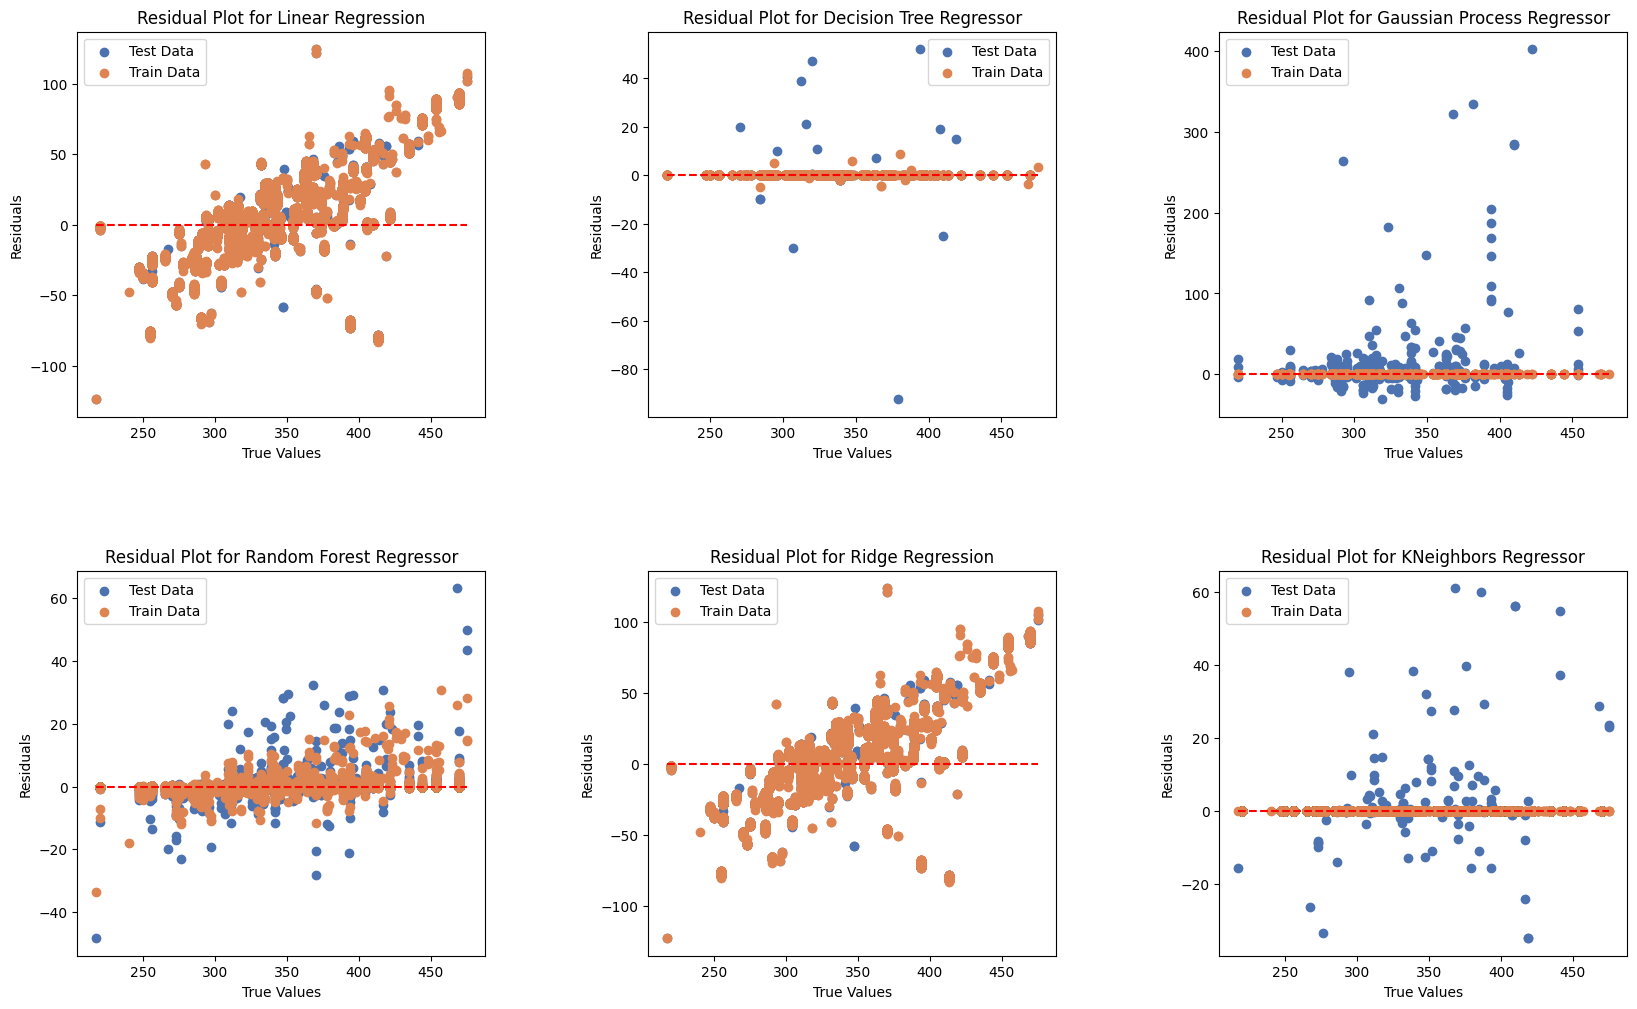

                        Model  \
0           Linear Regression   
1     Decision Tree Regressor   
2  Gaussian Process Regressor   
3     Random Forest Regressor   
4            Ridge Regression   
5        KNeighbors Regressor   

                                         Best Params   MSE Train     MSE Test  \
0                            {'fit_intercept': True}  967.651059   965.309846   
1  {'min_samples_split': 5, 'max_depth': 20, 'cri...    0.117063    20.485216   
2                                    {'alpha': 0.01}    0.001016  3077.034558   
3  {'n_estimators': 100, 'min_samples_split': 2, ...    0.887346     3.645407   
4               {'alpha': 1, 'fit_intercept': False}  967.663483   965.341938   
5  {'weights': 'distance', 'p': 1, 'n_neighbors': 3}    0.000000     3.419026   

   RMSE Train  RMSE Test  MAE Train   MAE Test  R2 Train   R2 Test  
0   31.107090  31.069436  23.046324  22.950628  0.580230  0.578999  
1    0.342145   4.526060   0.025238   0.467963  0.999947  0.99

In [19]:
# Feature Engineering to add more features to the data
def add_features(data):
    data['day_of_week'] = data['date_of_search'].dt.dayofweek  # Extracts the day of the week from date_of_search
    data['end_of_month'] = data['date_of_search'].dt.daysinmonth - data['date_of_search'].dt.day  # Calculates days until the end of the month
    data['week_of_year'] = data['date_of_search'].dt.isocalendar().week  # Extracts the week of the year from date_of_search
    data['is_weekend'] = data['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)  # Determines if the day is a weekend (Saturday or Sunday)
    data['start_of_month'] = data['date_of_search'].dt.day.apply(lambda x: 1 if x <= 7 else 0)  # Indicates if the day is within the first week of the month
    data['quarter'] = data['date_of_search'].dt.quarter  # Extracts the quarter of the year from date_of_search
    data['search_day'] = data['date_of_search'].dt.day  # Extracts the day of the month from date_of_search
    data['search_month'] = data['date_of_search'].dt.month  # Extracts the month from date_of_search
    data['search_year'] = data['date_of_search'].dt.year  # Extracts the year from date_of_search
    data.drop(['date_of_search'], axis=1, inplace=True)  # Drops the original date_of_search column from the DataFrame
    return data

# Applying the feature engineering
data_booking_processed = add_features(data_booking_processed)
data_expedia_processed = add_features(data_expedia_processed)

# Applying the function to both datasets to run the models
print("Booking Data:")
results_booking = train_and_evaluate_models(data_booking_processed, 'price_after_tax')
print(results_booking)

print("\nExpedia Data:")
results_expedia = train_and_evaluate_models(data_expedia_processed, 'price_after_tax')
print(results_expedia)

Since the changes with and without feature engineering are practically null, then I will train the following models for feature importance and normalization with the original data processed, the one that did not have feature engineering, this to reduce computational time

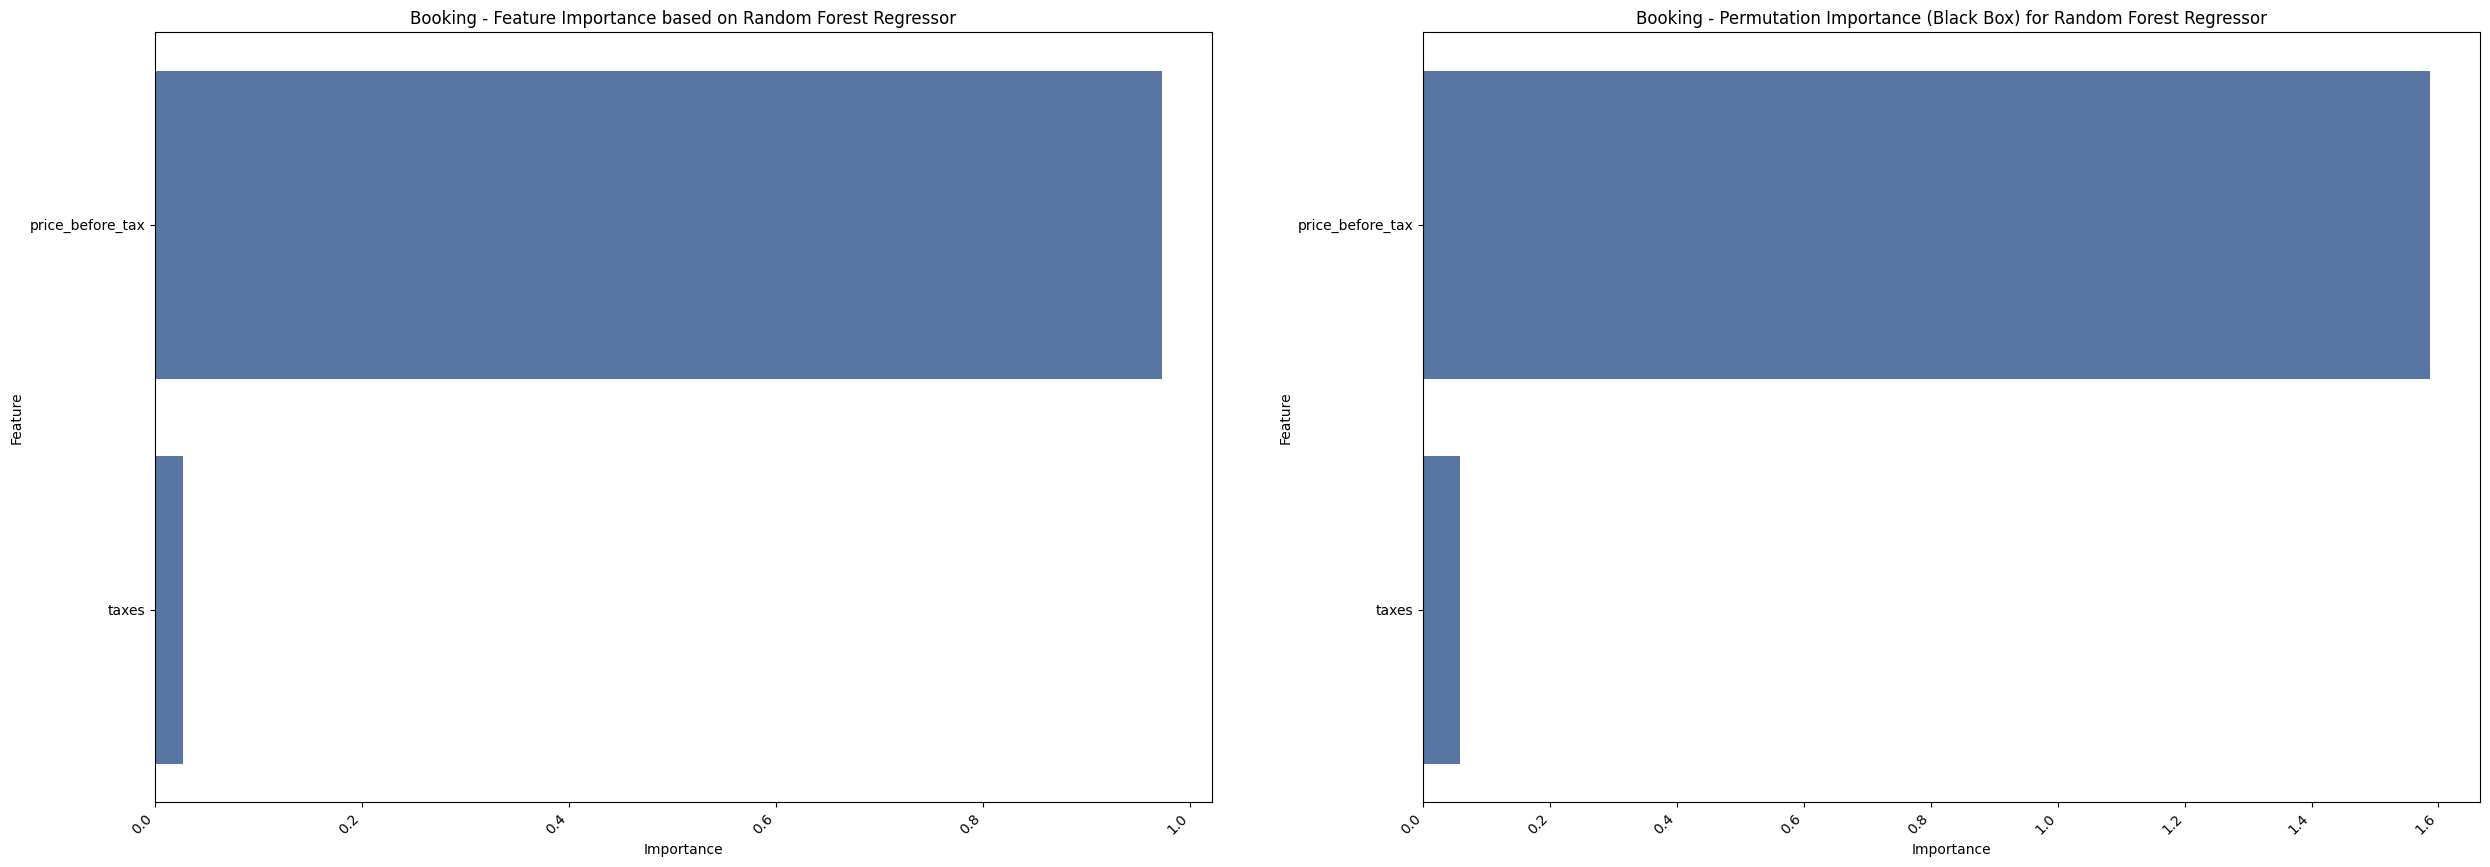

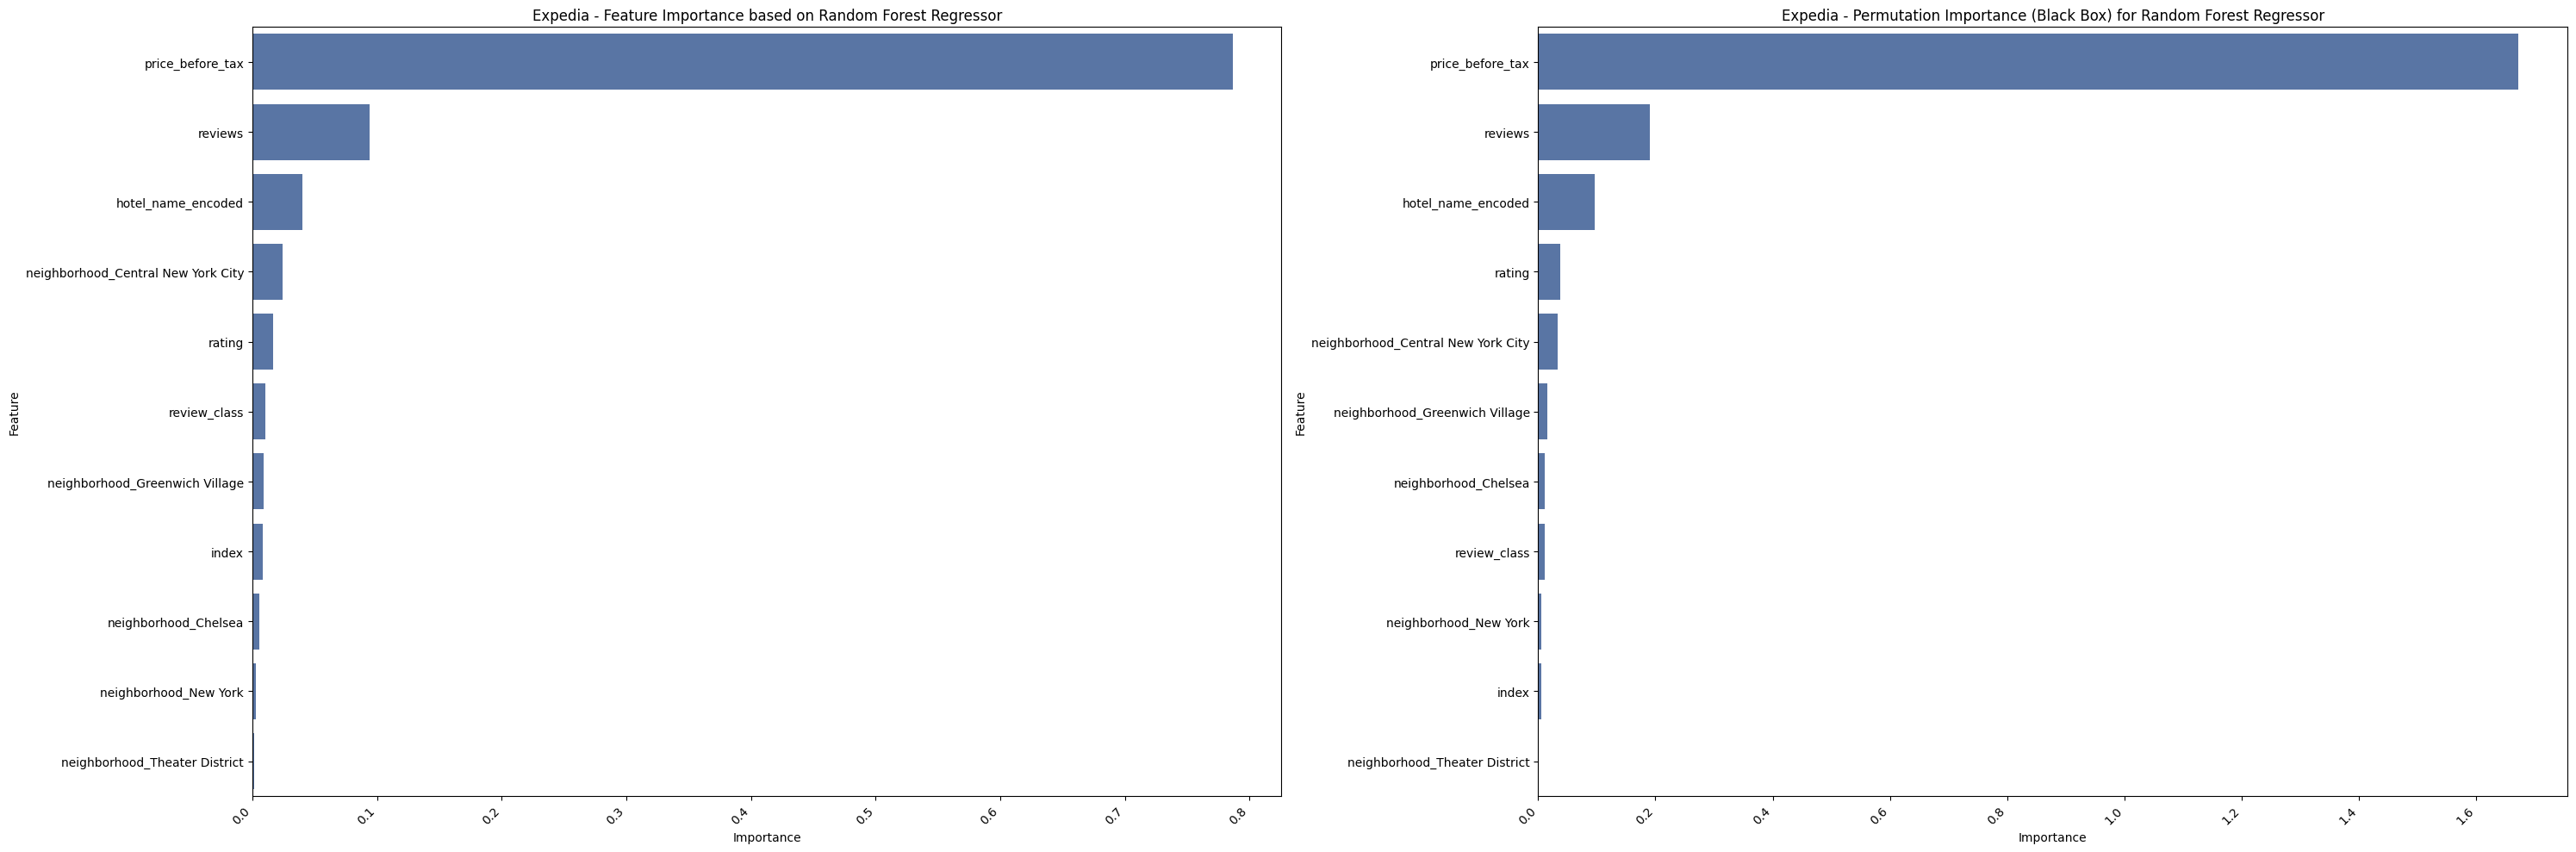

In [20]:
# Function to plot feature importance based on two methods
def feature_importance_analysis(model, X_train, y_train, model_name, dataset_name, axes, importance_threshold=0.001):
    # Method 1: Based on the specific algorithm
    importances = model.feature_importances_
    feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})
    # Filter features based on importance threshold
    feature_importance_df = feature_importance_df[feature_importance_df['Importance'] > importance_threshold]
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df, ax=axes[0])
    axes[0].set_title(f'{dataset_name} - Feature Importance based on {model_name}')

    # Method 2: Treating the model as a black box
    perm_importance = permutation_importance(model, X_train, y_train, n_repeats=10, random_state=42)
    perm_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': perm_importance.importances_mean})
    # Filter features based on importance threshold
    perm_importance_df = perm_importance_df[perm_importance_df['Importance'] > importance_threshold]
    perm_importance_df = perm_importance_df.sort_values(by='Importance', ascending=False)
    sns.barplot(x='Importance', y='Feature', data=perm_importance_df, ax=axes[1])
    axes[1].set_title(f'{dataset_name} - Permutation Importance (Black Box) for {model_name}')

# Extracting the best parameters tuned for the two models selected
# I selected Random forest and Ridge regression because they are the best models for the two datasets
df = pd.DataFrame(results_expedia) # Results dictionary to dataframe
best_parameters_random_forest = df[df['Model'] == 'Random Forest Regressor']['Best Params'].values[0]
best_parameters_ridge = df[df['Model'] == 'Ridge Regression']['Best Params'].values[0]

# Plots of feature importance for both datasets with the two methods side by side
fig, axs_booking = plt.subplots(1, 2, figsize=(30, 10))
fig, axs_expedia = plt.subplots(1, 2, figsize=(30, 10))

# Applying feature importance analysis for Random Forest Regressor on both datasets
rf_model_booking = RandomForestRegressor(**best_parameters_random_forest).fit(data_booking_processed.drop(columns=['price_after_tax']), data_booking_processed['price_after_tax'])
feature_importance_analysis(rf_model_booking, data_booking_processed.drop(columns=['price_after_tax']), data_booking_processed['price_after_tax'], "Random Forest Regressor", "Booking", axs_booking)

rf_model_expedia = RandomForestRegressor(**best_parameters_random_forest).fit(data_expedia_processed.drop(columns=['price_after_tax']), data_expedia_processed['price_after_tax'])
feature_importance_analysis(rf_model_expedia, data_expedia_processed.drop(columns=['price_after_tax']), data_expedia_processed['price_after_tax'], "Random Forest Regressor", "Expedia", axs_expedia)

# Improving layout and label rotation for better visibility
for ax in axs_booking:
    plt.sca(ax)
    plt.xticks(rotation=45, ha="right")
for ax in axs_expedia:
    plt.sca(ax)
    plt.xticks(rotation=45, ha="right")

plt.tight_layout()
plt.show()

In [ ]:
# Plots of feature importance for both datasets with the two methods side by side
fig, axs_booking = plt.subplots(1, 2, figsize=(30, 10))
fig, axs_expedia = plt.subplots(1, 2, figsize=(30, 10))

# Applying feature importance analysis for Ridge Regression on both datasets
ridge_booking = Ridge(**best_parameters_ridge).fit(data_booking_processed.drop(columns=['price_after_tax']), data_booking_processed['price_after_tax'])
feature_importance_analysis(ridge_booking, data_booking_processed.drop(columns=['price_after_tax']), data_booking_processed['price_after_tax'], "Ridge Regression", "Booking", axs_booking)

ridge_model_booking = Ridge(**best_parameters_ridge).fit(data_booking_processed.drop(columns=['price_after_tax']), data_booking_processed['price_after_tax'])
feature_importance_analysis(ridge_model_booking, data_booking_processed.drop(columns=['price_after_tax']), data_booking_processed['price_after_tax'], "Ridge Regression", "Booking", axs_booking)

# Improving layout and label rotation for better visibility
for ax in axs_booking:
    plt.sca(ax)
    plt.xticks(rotation=45, ha="right")
for ax in axs_expedia:
    plt.sca(ax)
    plt.xticks(rotation=45, ha="right")

plt.tight_layout()
plt.show()

Booking Data (Normalized):
Training Linear Regression...
Training Decision Tree Regressor...


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
15 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py", line 1247, in fit
    super().fit(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py", line 199, in fit
    raise ValueError(
ValueError: Some value(s) of y are negative which is not allowed for Poisson regression.

  

Training Gaussian Process Regressor...
Training Random Forest Regressor...
Training Ridge Regression...
Training KNeighbors Regressor...


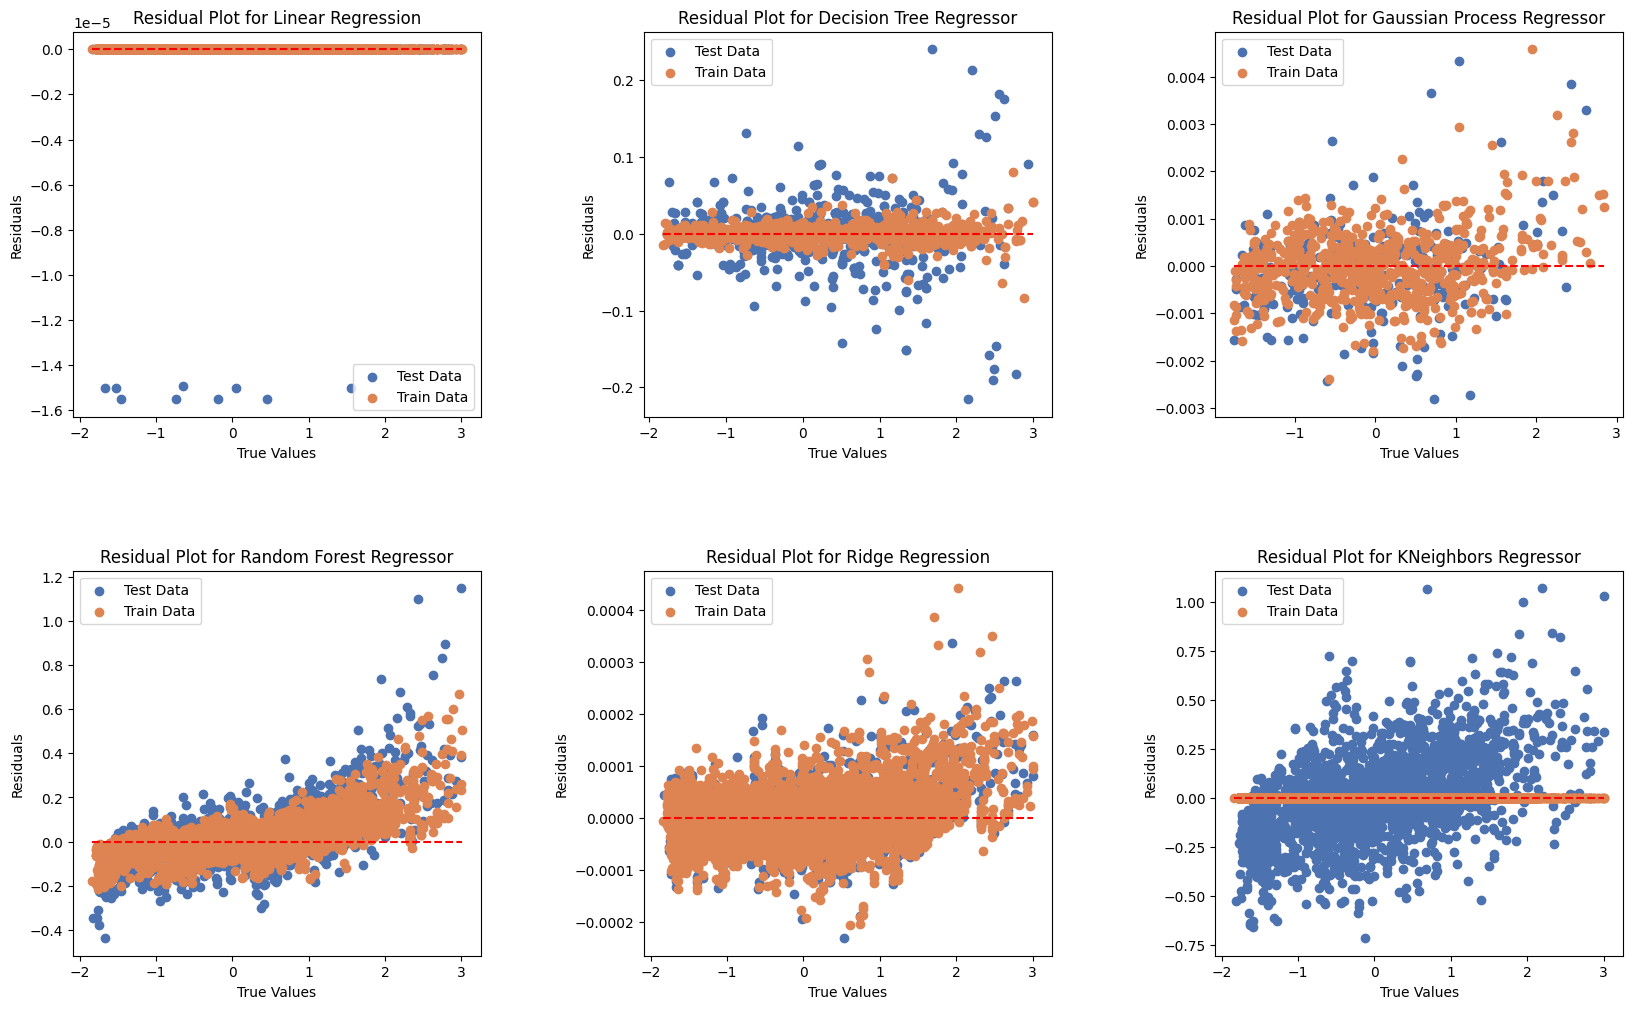

                        Model  \
0           Linear Regression   
1     Decision Tree Regressor   
2  Gaussian Process Regressor   
3     Random Forest Regressor   
4            Ridge Regression   
5        KNeighbors Regressor   

                                         Best Params     MSE Train  \
0                            {'fit_intercept': True}  2.803291e-30   
1  {'min_samples_split': 5, 'max_depth': 20, 'cri...  5.522988e-05   
2                                   {'alpha': 0.001}  5.145459e-07   
3  {'n_estimators': 100, 'min_samples_split': 2, ...  5.873222e-03   
4             {'alpha': 0.1, 'fit_intercept': False}  2.602397e-09   
5  {'weights': 'distance', 'p': 2, 'n_neighbors': 7}  4.979264e-15   

       MSE Test    RMSE Train     RMSE Test     MAE Train      MAE Test  \
0  9.411123e-13  1.674303e-15  9.701094e-07  1.325149e-15  6.181521e-08   
1  1.154304e-03  7.431681e-03  3.397506e-02  3.446489e-03  1.753683e-02   
2  8.241379e-07  7.173186e-04  9.078204e-04  5.29102

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
15 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py", line 1247, in fit
    super().fit(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py", line 199, in fit
    raise ValueError(
ValueError: Some value(s) of y are negative which is not allowed for Poisson regression.

  

Training Gaussian Process Regressor...
Training Random Forest Regressor...
Training Ridge Regression...
Training KNeighbors Regressor...


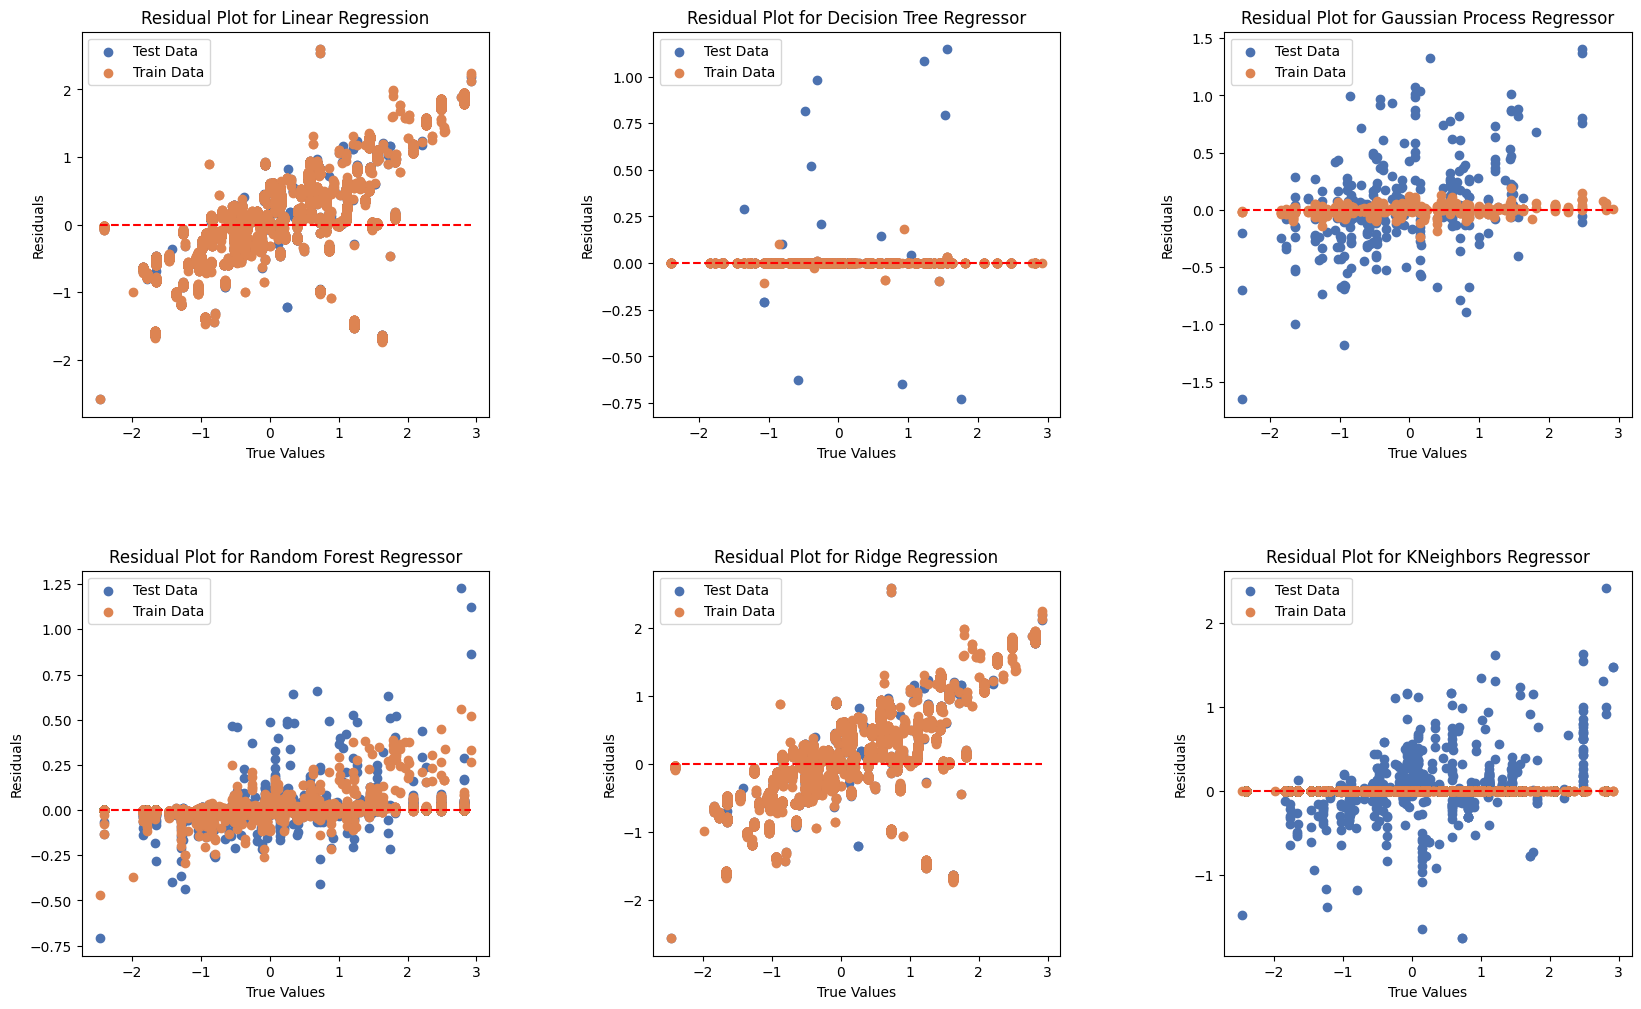

                        Model  \
0           Linear Regression   
1     Decision Tree Regressor   
2  Gaussian Process Regressor   
3     Random Forest Regressor   
4            Ridge Regression   
5        KNeighbors Regressor   

                                         Best Params  MSE Train  MSE Test  \
0                            {'fit_intercept': True}   0.420438  0.419421   
1  {'min_samples_split': 5, 'max_depth': 20, 'cri...   0.000040  0.007343   
2                                    {'alpha': 0.01}   0.001174  0.167573   
3  {'n_estimators': 100, 'min_samples_split': 2, ...   0.000346  0.001375   
4                {'alpha': 1, 'fit_intercept': True}   0.420444  0.419433   
5  {'weights': 'distance', 'p': 1, 'n_neighbors': 3}   0.000000  0.010283   

   RMSE Train  RMSE Test  MAE Train  MAE Test  R2 Train   R2 Test  
0    0.648412   0.647627   0.480389  0.478395  0.580230  0.578999  
1    0.006308   0.085694   0.000387  0.009650  0.999959  0.992768  
2    0.034270   0.409357

In [21]:
# Normalization techniques applied in the data
# I selected two normalization techniques, Standard Scaler and MinMax Scaler
def normalize_data(data, scaler_type='standard'):
    if scaler_type == 'standard':
        scaler = StandardScaler()
    elif scaler_type == 'minmax':
        scaler = MinMaxScaler()
    
    numeric_features = data.select_dtypes(include=[np.number]).columns.tolist()
    data[numeric_features] = scaler.fit_transform(data[numeric_features])
    return data

# Apply normalization and evaluate models with both scalers
scalers = ['standard', 'minmax']

for scaler_type in scalers:
    print(f"Using {scaler_type.capitalize()} Scaler")
    
    data_booking_normalized = normalize_data(data_booking_processed.copy(), scaler_type)
    data_expedia_normalized = normalize_data(data_expedia_processed.copy(), scaler_type)
    
    print("Booking Data (Normalized):")
    results_booking_normalized = train_and_evaluate_models(data_booking_normalized, 'price_after_tax')
    print(results_booking_normalized)
    
    print("\nExpedia Data (Normalized):")
    results_expedia_normalized = train_and_evaluate_models(data_expedia_normalized, 'price_after_tax')
    print(results_expedia_normalized)
    print("\n" + "="*50 + "\n")

Booking Data (Future Split):


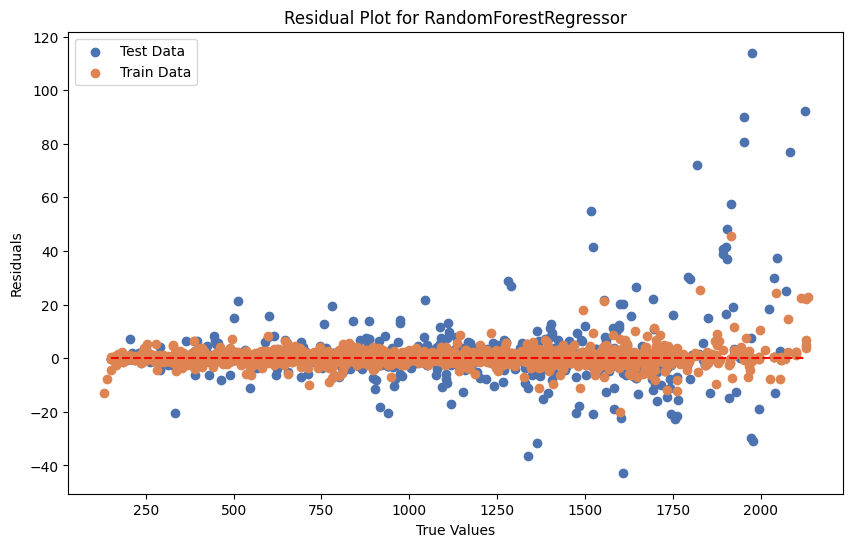

{'Model': 'RandomForestRegressor', 'MSE Train': 2.50007465277778, 'MSE Test': 75.52968877245507, 'RMSE Train': 1.5811624371891018, 'RMSE Test': 8.690781827456899, 'MAE Train': 0.5978025793650753, 'MAE Test': 3.06571856287425, 'R2 Train': 0.9999849515787701, 'R2 Test': 0.9995957014378306}

Expedia Data (Future Split):


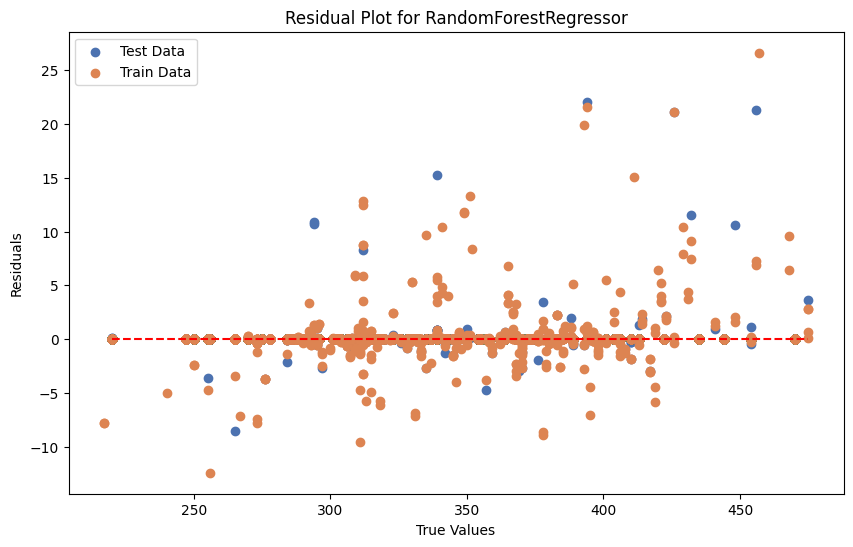

{'Model': 'RandomForestRegressor', 'MSE Train': 0.20506009806825282, 'MSE Test': 0.3936704116778743, 'RMSE Train': 0.45283561925742194, 'RMSE Test': 0.627431599202554, 'MAE Train': 0.02739395136077925, 'MAE Test': 0.035255043463998666, 'R2 Train': 0.9999105025380576, 'R2 Test': 0.9998326786673546}


In [22]:
# Additional Experiment with Different Train/Test Split
def split_train_test_future(data, target_column, ttt_threshold):
    train_data = data[data['ttt'] <= ttt_threshold]
    test_data = data[data['ttt'] > ttt_threshold]

    X_train = train_data.drop(columns=[target_column])
    y_train = train_data[target_column]
    X_test = test_data.drop(columns=[target_column])
    y_test = test_data[target_column]

    return X_train, X_test, y_train, y_test

def train_and_evaluate_best_model(data, target_column, best_model):
    X_train, X_test, y_train, y_test = split_train_test_future(data, target_column, 25)

    best_model.fit(X_train, y_train)
    y_pred_train = best_model.predict(X_train)
    y_pred_test = best_model.predict(X_test)

    # Calculate error metrics
    mse_train = mean_squared_error(y_train, y_pred_train)
    mse_test = mean_squared_error(y_test, y_pred_test)
    rmse_train = np.sqrt(mse_train)
    rmse_test = np.sqrt(mse_test)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    mae_test = mean_absolute_error(y_test, y_pred_test)
    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)

    results = {
        "Model": best_model.__class__.__name__,
        "MSE Train": mse_train,
        "MSE Test": mse_test,
        "RMSE Train": rmse_train,
        "RMSE Test": rmse_test,
        "MAE Train": mae_train,
        "MAE Test": mae_test,
        "R2 Train": r2_train,
        "R2 Test": r2_test
    }

    # Plot residuals
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_test - y_pred_test, label="Test Data")
    plt.scatter(y_train, y_train - y_pred_train, label="Train Data")
    plt.hlines(y=0, xmin=min(y_test), xmax=max(y_test), colors='r', linestyles='dashed')
    plt.xlabel("True Values")
    plt.ylabel("Residuals")
    plt.title(f"Residual Plot for {best_model.__class__.__name__}")
    plt.legend()
    plt.show()

    return results

# Train and evaluate the best model with different split
best_model = RandomForestRegressor()  # Assuming Random Forest Regressor is the best model
print("Booking Data (Future Split):")
results_booking_future_split = train_and_evaluate_best_model(data_booking_processed, 'price_after_tax', best_model)
print(results_booking_future_split)

print("\nExpedia Data (Future Split):")
results_expedia_future_split = train_and_evaluate_best_model(data_expedia_processed, 'price_after_tax', best_model)
print(results_expedia_future_split)

## Part D - Learning the difference in prices between the competitors websites

In [61]:
data_booking_processed.drop(columns=['date_of_search'], inplace=True)
data_expedia_processed.drop(columns=['date_of_search'], inplace=True)

(131, 28)
Training Linear Regression...
Training Decision Tree Regressor...


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
15 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py", line 1247, in fit
    super().fit(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py", line 199, in fit
    raise ValueError(
ValueError: Some value(s) of y are negative which is not allowed for Poisson regression.

  

Training Gaussian Process Regressor...
Training Random Forest Regressor...
Training Ridge Regression...
Training KNeighbors Regressor...


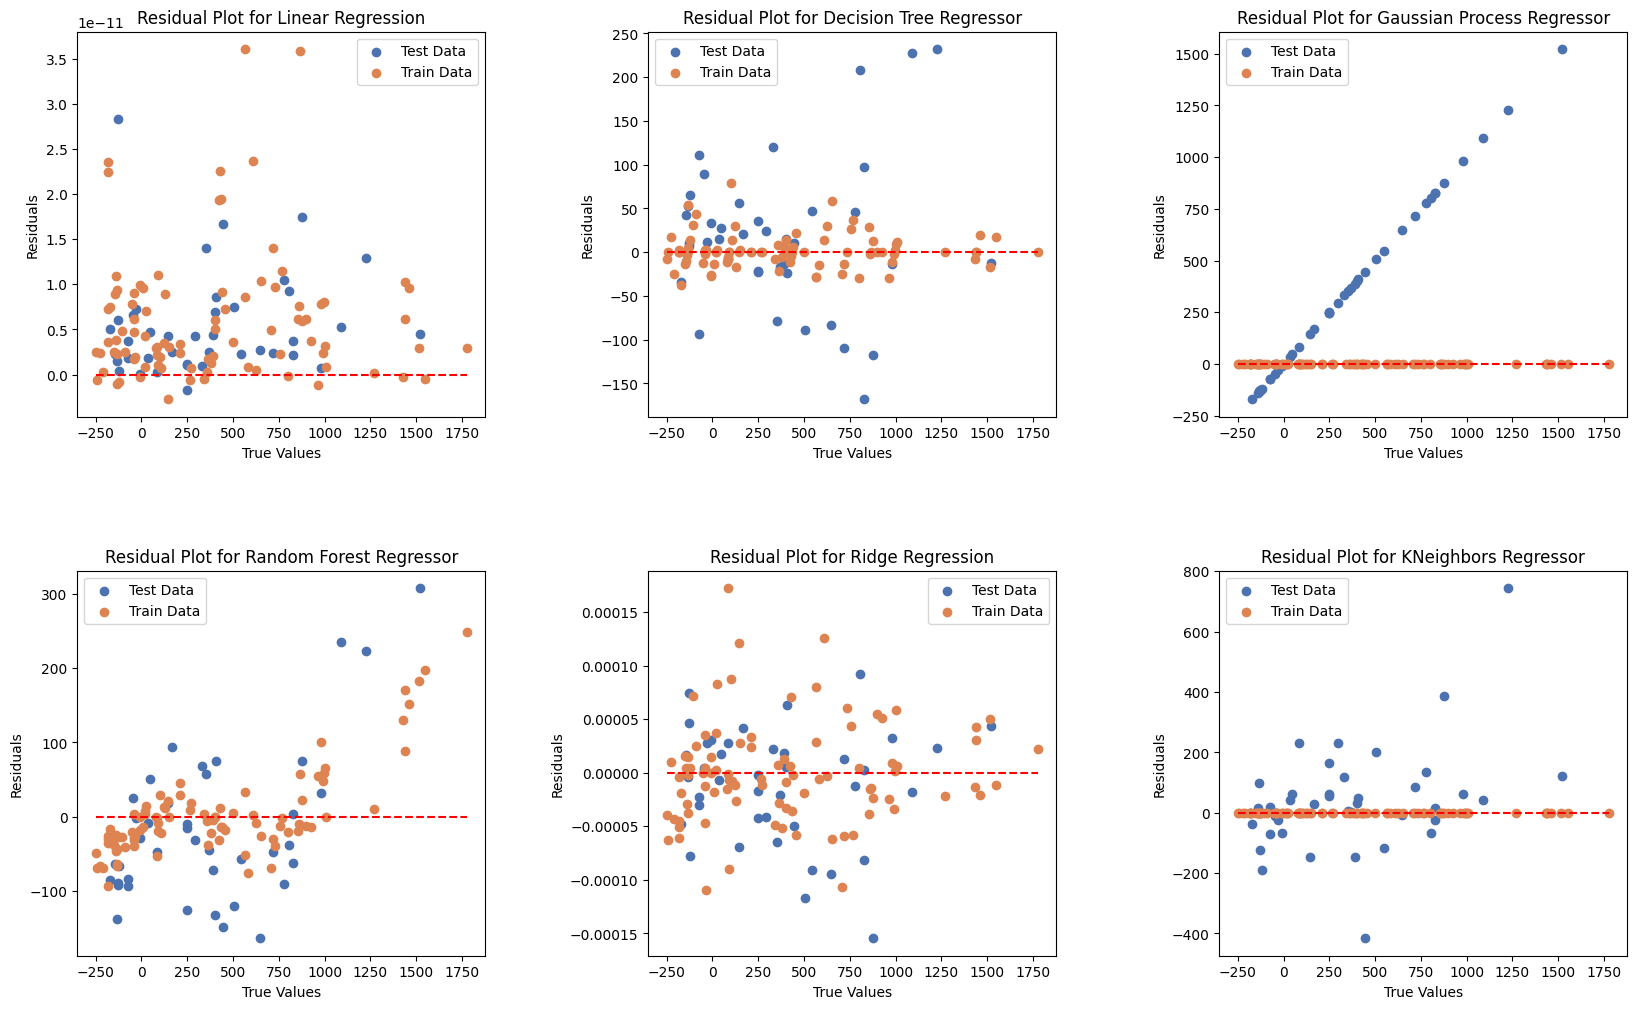

                        Model  \
0           Linear Regression   
1     Decision Tree Regressor   
2  Gaussian Process Regressor   
3     Random Forest Regressor   
4            Ridge Regression   
5        KNeighbors Regressor   

                                         Best Params     MSE Train  \
0                           {'fit_intercept': False}  8.914130e-23   
1  {'min_samples_split': 2, 'max_depth': 5, 'crit...  3.665604e+02   
2                                    {'alpha': 0.01}  4.065919e-05   
3  {'n_estimators': 100, 'min_samples_split': 2, ...  3.514469e+03   
4             {'alpha': 0.1, 'fit_intercept': False}  2.208287e-09   
5  {'weights': 'distance', 'p': 1, 'n_neighbors': 3}  0.000000e+00   

       MSE Test    RMSE Train     RMSE Test     MAE Train      MAE Test  \
0  6.234833e-23  9.441467e-12  7.896096e-12  6.274785e-12  5.515854e-12   
1  7.554387e+03  1.914577e+01  8.691598e+01  1.218681e+01  6.285000e+01   
2  3.090718e+05  6.376456e-03  5.559423e+02  4.62852

In [62]:
import pandas as pd
import numpy as np

# Assuming data_booking_processed and data_expedia_processed are already preprocessed as described before

# Drop duplicates based on 'hotel_name_encoded' to ensure unique hotel entries
data_booking_processed = data_booking_processed.drop_duplicates(subset=['hotel_name_encoded'])
data_expedia_processed = data_expedia_processed.drop_duplicates(subset=['hotel_name_encoded'])

# Find mutual hotels and merge on 'hotel_name_encoded'
mutual_hotels = pd.merge(data_booking_processed, data_expedia_processed, on='hotel_name_encoded', suffixes=('_booking', '_expedia'))

# Selecting relevant columns for the model
# This includes selecting mutual columns excluding 'hotel_name_encoded'
mutual_columns_booking = set(data_booking_processed.columns) & set(data_expedia_processed.columns)
mutual_columns_expedia = set(data_expedia_processed.columns) & set(data_booking_processed.columns)

# Ensuring 'hotel_name_encoded' is not included twice
mutual_columns_booking = [col for col in mutual_columns_booking if col != 'hotel_name_encoded']
mutual_columns_expedia = [col for col in mutual_columns_expedia if col != 'hotel_name_encoded']

# Create the target variable 'price_difference'
mutual_hotels['price_difference'] = mutual_hotels['price_after_tax_booking'] - mutual_hotels['price_after_tax_expedia']

# Prepare the final dataframe for modeling
columns_to_keep = ['hotel_name_encoded'] + [col + '_booking' for col in mutual_columns_booking] + [col + '_expedia' for col in mutual_columns_expedia] + ['price_difference']
model_data = mutual_hotels[columns_to_keep]

# Overview of the data
print(model_data.shape)
model_data.head(2)

# Step 5: Define the target column
target_column = 'price_difference'

# Step 6: Train and evaluate models
results_df = train_and_evaluate_models(model_data, target_column)
print(results_df)


In [63]:
mutual_hotels.shape

(131, 224)

## Part E - perform Reverse Engineering to the sorting algorithms of the websites

In [ ]:
data_booking_normalized

In [69]:
# Combining and splitting the data, data preprocessed in part B
common_columns = list(set(data_booking_normalized.columns) & set(data_expedia_normalized.columns))
expedia_data = data_expedia_normalized[common_columns]
booking_data = data_booking_normalized[common_columns]

unified_data = pd.concat([expedia_data, booking_data], ignore_index=True)
unified_data.head(3)

,index,price_before_tax,search_day,neighborhood_Greenwich Village,ttt,neighborhood_Chelsea,hotel_name_encoded,reviews,week_of_year,search_month,is_weekend,day_of_week,neighborhood_Upper West Side,los,search_year,neighborhood_New York,review_class,end_of_month,quarter,price_after_tax,neighborhood_SoHo,rating,start_of_month
0,-1.707013,-0.484442,0.316976,False,-1.714855,False,0.160871,0.008858,-1.236757,-0.700996,0.0,0.0,False,-1.405324,0.0,True,-0.932561,-0.316976,0.0,0.042401,False,-0.832708,-0.700996
1,-1.672026,-0.014293,0.316976,False,-1.714855,True,0.221227,-0.368602,-1.236757,-0.700996,0.0,0.0,False,-1.405324,0.0,False,0.032017,-0.316976,0.0,0.730270,False,-0.076259,-0.700996
2,-1.637040,1.216389,0.316976,False,-1.714855,False,0.402294,-0.877443,-1.236757,-0.700996,0.0,0.0,False,-1.405324,0.0,False,1.961173,-0.316976,0.0,1.564051,False,1.436640,-0.700996


In [70]:
unified_data.shape

(43868, 23)

Training Linear Regression...


ValueError: Cannot have number of splits n_splits=5 greater than the number of samples: n_samples=0.

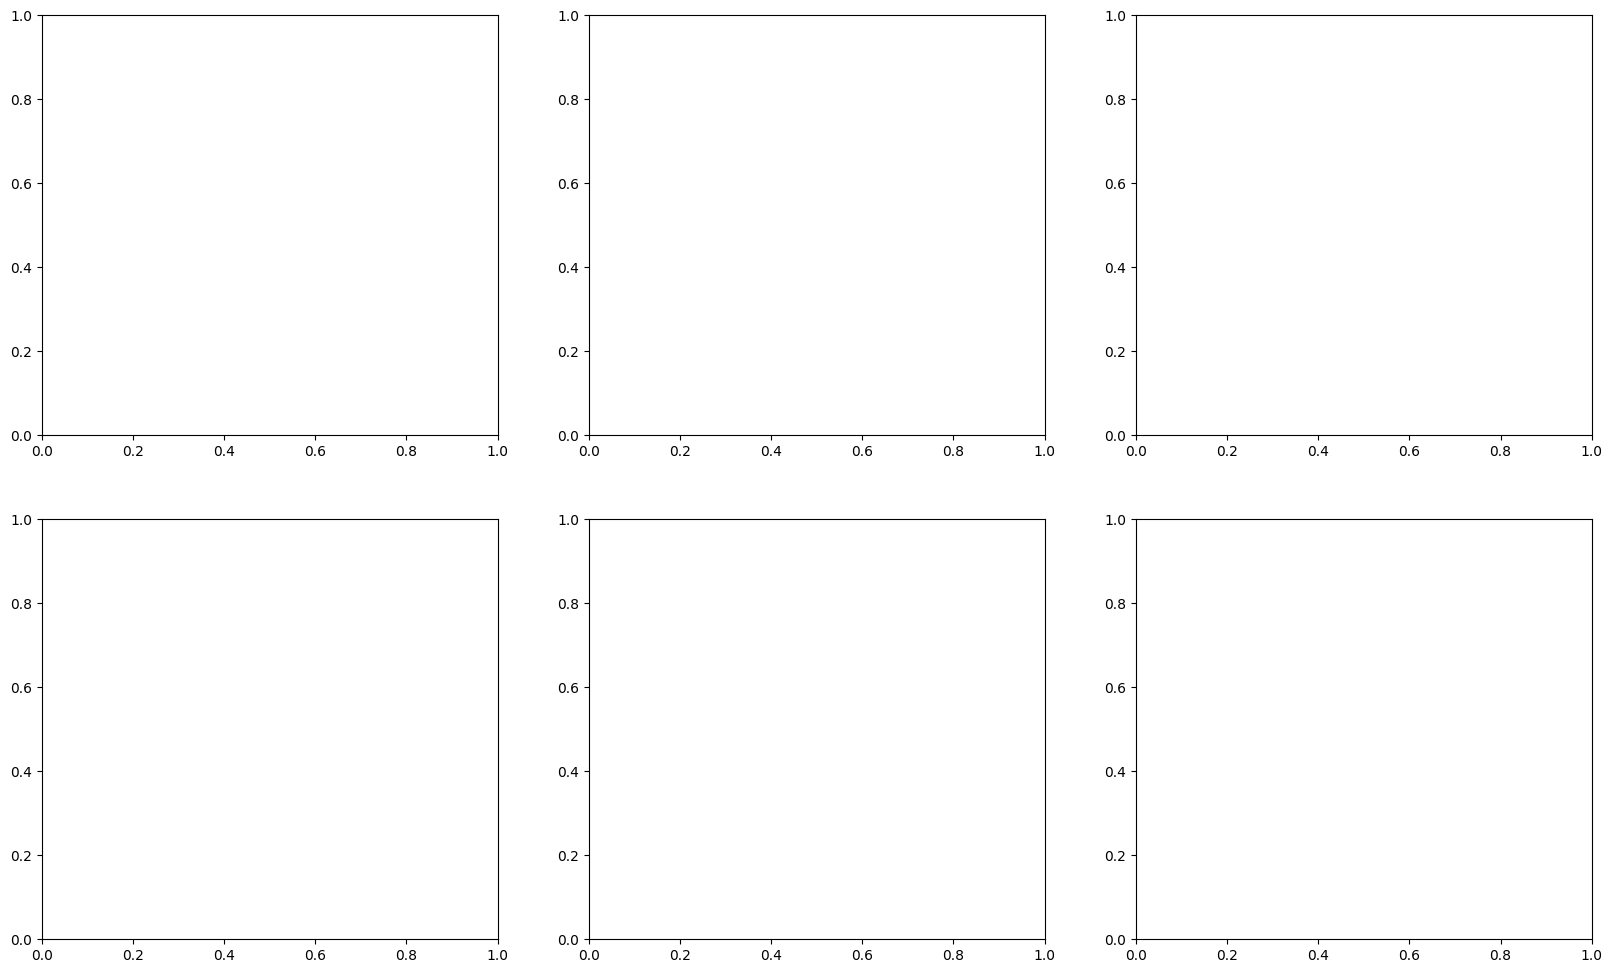

In [71]:
def train_and_evaluate_models_reverse_engineering(data):
    """
    Trains multiple regression models on a given dataset, evaluates their performance, and calculates error metrics.
    Also, plots residuals of each model in a grid layout.

    Parameters:
        data (pd.DataFrame): The dataset containing features and target variable.

    Returns:
        pd.DataFrame: A DataFrame containing the performance metrics of each model.
    """
    # Splitting the data into training and test sets based on ttt values
    train_data = data[data['ttt'] % 2 == 0]
    test_data = data[data['ttt'] % 2 != 0]

    # Target variable is hotel_index
    X_train = train_data.drop(columns=['index'])
    y_train = train_data['index']
    X_test = test_data.drop(columns=['index'])
    y_test = test_data['index']
    shuffled_indices = np.random.permutation(len(X_test))
    X_test_shuffled = X_test.iloc[shuffled_indices]
    y_test_shuffled = y_test.iloc[shuffled_indices]

    # Define parameter grids for hyperparameter tuning
    param_grids = {
        'Linear Regression': {
            'fit_intercept': [True, False]
        },
        'Decision Tree Regressor': {
            'max_depth': [5, 10, 20, None],
            'min_samples_split': [2, 5, 10],
            'criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson']
        },
        'Gaussian Process Regressor': {
            'alpha': [1e-2, 1e-3, 1e-4],
            'kernel': [C(1.0, (1e-4, 1e3)) * RBF(1.0, (1e-4, 1e2)), C(1.0, (1e-4, 1e3)) * Matern(nu=1.5)]
        },
        'Random Forest Regressor': {
            'n_estimators': [50, 100, 200],
            'max_features': ['sqrt', 'log2'],
            'max_depth': [10, 20, None],
            'min_samples_split': [2, 5, 10]
        },
        'Ridge': {
            'alpha': [0.1, 1, 10],
            'fit_intercept': [True, False]
        },
        'KNeighbors Regressor': {
            'n_neighbors': [3, 5, 7, 10],
            'weights': ['uniform', 'distance'],
            'p': [1, 2]
        }
    }

    # Models to be trained
    models = {
        "Linear Regression": LinearRegression(),
        "Decision Tree Regressor": DecisionTreeRegressor(),
        "Gaussian Process Regressor": GaussianProcessRegressor(),
        "Random Forest Regressor": RandomForestRegressor(),
        "Ridge": Ridge(),
        "KNeighbors Regressor": KNeighborsRegressor()
    }

    # Dictionary to store results
    results = []

    fig, axs = plt.subplots(2, 3, figsize=(20, 12))
    plot_row, plot_col = 0, 0

    # Evaluate each model
    for model_name, model in models.items():
        print(f"Training {model_name}...")
        if model_name == "Decision Tree Regressor":
            X_train_sampled = X_train.sample(n=5000, random_state=42)
            y_train_sampled = y_train.loc[X_train_sampled.index]
            X_train = X_train_sampled
            y_train = y_train_sampled
        elif model_name == "Gaussian Process Regressor":
            X_train_sampled = X_train.sample(n=1000, random_state=42)
            y_train_sampled = y_train.loc[X_train_sampled.index]
            X_train = X_train_sampled
            y_train = y_train_sampled

        # Use GridSearchCV if the number of parameter combinations is small, otherwise RandomizedSearchCV
        if model_name in param_grids:
            param_grid = param_grids[model_name]
            if len(param_grid) * len(list(param_grid.values())[0]) <= 10:
                model = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
            else:
                model = RandomizedSearchCV(model, param_grid, cv=5, n_iter=10, scoring='neg_mean_squared_error', n_jobs=-1, random_state=42)

        model.fit(X_train, y_train)

        best_model = model.best_estimator_ if hasattr(model, 'best_estimator_') else model
        y_pred_train = best_model.predict(X_train)
        y_pred_test = best_model.predict(X_test_shuffled)

        # Calculate metrics
        mse_train = mean_squared_error(y_train, y_pred_train)
        mse_test = mean_squared_error(y_test_shuffled, y_pred_test)
        rmse_train = np.sqrt(mse_train)
        rmse_test = np.sqrt(mse_test)
        mae_train = mean_absolute_error(y_train, y_pred_train)
        mae_test = mean_absolute_error(y_test_shuffled, y_pred_test)
        r2_train = r2_score(y_train, y_pred_train)
        r2_test = r2_score(y_test_shuffled, y_pred_test)

        results.append({
            "Model": model_name,
            "Best Params": model.best_params_ if hasattr(model, 'best_params_') else None,
            "MSE Train": mse_train,
            "MSE Test": mse_test,
            "RMSE Train": rmse_train,
            "RMSE Test": rmse_test,
            "MAE Train": mae_train,
            "MAE Test": mae_test,
            "R2 Train": r2_train,
            "R2 Test": r2_test
        })

        # Plot residuals in the grid
        ax = axs[plot_row, plot_col]
        ax.scatter(y_test_shuffled, y_test_shuffled - y_pred_test, label="Test Data")
        ax.scatter(y_train, y_train - y_pred_train, label="Train Data")
        ax.hlines(y=0, xmin=min(y_train.min(), y_test_shuffled.min()), xmax=max(y_train.max(), y_test_shuffled.max()), colors='r', linestyles='dashed')
        ax.set_xlabel("True Values")
        ax.set_ylabel("Residuals")
        ax.set_title(f"Residual Plot for {model_name}")
        ax.legend()

        # Update subplot index
        plot_col += 1
        if plot_col > 2:
            plot_col = 0
            plot_row += 1

    plt.tight_layout()
    plt.show()

    # Display results
    results_df = pd.DataFrame(results)
    return results_df

results_df = train_and_evaluate_models_reverse_engineering(unified_data)
print(results_df)